# Modelo Dixon-Coles con xG

Implementacion del modelo **Dixon-Coles (1997)** modificado para usar **xG** en lugar de goles reales.

## Por que xG en vez de goles?

Los goles reales tienen mucho ruido:
- Un equipo puede meter 3 de 3 tiros un dia
- Y 0 de 15 tiros otro dia

El **xG** es un proxy de "lo que deberia haber pasado" segun la calidad de las ocasiones. Hace que las estimaciones de ataque/defensa sean mas **estables y predictivas**.

## El truco: entrenar con xG, predecir goles

- **Entrenamiento**: Usamos xG continuo (ej: 1.73, 2.15)
- **Prediccion**: El modelo predice probabilidades de goles discretos (0, 1, 2, 3...)

Asi aprovechamos la estabilidad del xG sin romper la logica de Poisson.

**Referencia**: Dixon, M. J., & Coles, S. G. (1997). Modelling association football scores and inefficiencies in the football betting market.

## 1. Datos y Calculo de xG

In [1]:
from understatapi import UnderstatClient
import pandas as pd
import numpy as np
from time import sleep
from tqdm.auto import tqdm
from scipy.optimize import minimize, curve_fit
from scipy.stats import poisson
import matplotlib.pyplot as plt

In [ ]:
# Configuracion
# Ligas disponibles: "EPL", "La_Liga", "Bundesliga", "Serie_A", "Ligue_1", "RFPL"
LEAGUE = "EPL"
SEASON = ["2024","2025"]

# Dimensiones del campo (metros)
PITCH_LENGTH_M = 100.0
PITCH_WIDTH_M = 65.0
GOAL_CENTER_Y = 0.5

# Parametros de binning para modelo xG
BIN_WIDTH = 1.0
ALPHA = 1.0
LOW_N = 10
D_MIN, D_MAX = 2.0, 33.0

In [ ]:
import os
import json as json_lib
from datetime import datetime, timedelta

CACHE_DIR = "cache"
CACHE_TTL_HOURS = 12  # Datos validos por 12 horas

def get_cache_path(league, season, data_type):
    """Genera path del archivo de cache."""
    os.makedirs(CACHE_DIR, exist_ok=True)
    season_str = "_".join(season) if isinstance(season, list) else season
    return os.path.join(CACHE_DIR, f"{league}_{season_str}_{data_type}.json")

def is_cache_valid(filepath, ttl_hours=CACHE_TTL_HOURS):
    """Verifica si el cache existe y no ha expirado."""
    if not os.path.exists(filepath):
        return False
    mtime = datetime.fromtimestamp(os.path.getmtime(filepath))
    return datetime.now() - mtime < timedelta(hours=ttl_hours)

def save_cache(data, filepath):
    """Guarda datos en cache."""
    with open(filepath, "w", encoding="utf-8") as f:
        json_lib.dump(data, f)

def load_cache(filepath):
    """Carga datos del cache."""
    with open(filepath, "r", encoding="utf-8") as f:
        return json_lib.load(f)


def get_league_match_ids(league: str, seasons: list[str], use_cache=True):
    """Retorna lista de match_ids y metadatos por liga y temporadas."""
    cache_path = get_cache_path(league, seasons, "matches")
    
    # Intentar cargar del cache
    if use_cache and is_cache_valid(cache_path):
        print(f"[CACHE] Cargando partidos desde cache...")
        data = load_cache(cache_path)
        return data["match_ids"], data["matches"]
    
    # Descargar de la API
    print(f"[API] Descargando partidos de Understat...")
    all_match_ids = []
    all_matches = []
    with UnderstatClient() as us:
        for season in seasons:
            matches = us.league(league=league).get_match_data(season=season)
            all_match_ids.extend([m["id"] for m in matches])
            all_matches.extend(matches)
    
    # Guardar en cache
    if use_cache:
        save_cache({"match_ids": all_match_ids, "matches": all_matches}, cache_path)
        print(f"[CACHE] Guardado en {cache_path}")
    
    return all_match_ids, all_matches


def fetch_all_shots(match_ids, league, seasons, use_cache=True):
    """Descarga todos los tiros con cache."""
    cache_path = get_cache_path(league, seasons, "shots")
    
    # Intentar cargar del cache
    if use_cache and is_cache_valid(cache_path):
        print(f"[CACHE] Cargando tiros desde cache...")
        return load_cache(cache_path)
    
    # Descargar de la API
    print(f"[API] Descargando tiros de {len(match_ids)} partidos...")
    all_shots = []
    with UnderstatClient() as us:
        for mid in tqdm(match_ids, desc=f"Descargando tiros {league}"):
            try:
                all_shots.extend(fetch_match_shots(mid, us))
            except Exception:
                pass
            sleep(0.15)
    
    # Guardar en cache
    if use_cache:
        save_cache(all_shots, cache_path)
        print(f"[CACHE] Guardado en {cache_path}")
    
    return all_shots


def fetch_match_shots(match_id: str, client: UnderstatClient) -> list[dict]:
    """Obtiene tiros de un partido."""
    out = []
    md = client.match(match=match_id).get_shot_data()
    for side in ("h", "a"):
        for s in md.get(side, []):
            s = dict(s)
            s["h_a"] = side
            s["match_id"] = match_id
            out.append(s)
    return out


def shots_to_df(shots: list[dict]) -> pd.DataFrame:
    """Convierte lista de tiros a DataFrame, incluyendo xG de Understat."""
    rows = []
    for s in shots:
        rows.append({
            "match_id": s.get("match_id"),
            "team": s.get("h_team") if s.get("h_a") == "h" else s.get("a_team"),
            "h_a": s.get("h_a"),
            "X": float(s.get("X")),
            "Y": float(s.get("Y")),
            "is_goal": 1 if s.get("result") == "Goal" else 0,
            "situation": s.get("situation"),
            "xg_understat": float(s.get("xG", 0))
        })
    df = pd.DataFrame(rows)
    return df.dropna(subset=["X", "Y"]).reset_index(drop=True)


def clear_cache(league=None):
    """Limpia el cache (todo o de una liga especifica)."""
    if not os.path.exists(CACHE_DIR):
        print("No hay cache")
        return
    
    files = os.listdir(CACHE_DIR)
    if league:
        files = [f for f in files if f.startswith(league)]
    
    for f in files:
        os.remove(os.path.join(CACHE_DIR, f))
        print(f"  Eliminado: {f}")
    
    print(f"Cache limpiado: {len(files)} archivos")

In [ ]:
# Descargar datos (con cache automatico)
USE_CACHE = True  # False para forzar descarga fresca

# Obtener partidos
match_ids, raw_matches = get_league_match_ids(LEAGUE, SEASON, use_cache=USE_CACHE)
print(f"Partidos encontrados: {len(match_ids)}")

# Obtener tiros
all_shots = fetch_all_shots(match_ids, LEAGUE, SEASON, use_cache=USE_CACHE)

# Convertir a DataFrame y filtrar penales/tiros libres
df_shots = shots_to_df(all_shots)
df_shots = df_shots[~df_shots["situation"].isin(["Penalty", "DirectFreekick"])]
print(f"Tiros (open play): {len(df_shots)}")

# Para limpiar cache: clear_cache("EPL")

In [ ]:
# OPCION: Elegir fuente de xG
# True = usar xG de Understat (mas sofisticado: incluye angulo, tipo de tiro, situacion)
# False = calcular xG con modelo exponencial simple (solo distancia)
USE_UNDERSTAT_XG = True

if USE_UNDERSTAT_XG:
    # Usar xG de Understat directamente
    df_shots["xg"] = df_shots["xg_understat"]
    print("Usando xG de Understat (incluye angulo, tipo de tiro, situacion de juego)")
else:
    # Calcular xG con modelo exponencial (solo distancia)
    # Estandarizar coordenadas (todos los tiros hacia X=1)
    mask = df_shots["X"] < 0.5
    df_shots.loc[mask, "X"] = 1 - df_shots.loc[mask, "X"]
    
    # Calcular distancias
    df_shots["dist_long_m"] = (1.0 - df_shots["X"]) * PITCH_LENGTH_M
    df_shots["dist_lateral_m"] = np.abs(df_shots["Y"] - GOAL_CENTER_Y) * PITCH_WIDTH_M
    df_shots["dist_euclid_m"] = np.sqrt(df_shots["dist_long_m"]**2 + df_shots["dist_lateral_m"]**2)
    
    # Binning y ajuste exponencial
    bins = np.arange(0.0, np.ceil(df_shots["dist_euclid_m"].max()) + BIN_WIDTH, BIN_WIDTH)
    df_shots["dist_bin"] = pd.cut(df_shots["dist_euclid_m"], bins=bins, right=False)
    bin_stats = (
        df_shots.groupby("dist_bin", observed=True)
        .agg(shots=("is_goal", "size"), goals=("is_goal", "sum"),
             d_min=("dist_euclid_m", "min"), d_max=("dist_euclid_m", "max"))
        .dropna(subset=["d_min", "d_max"]).reset_index(drop=True)
    )
    bin_stats["d_mid"] = 0.5 * (bin_stats["d_min"] + bin_stats["d_max"])
    bin_stats["p_goal"] = (bin_stats["goals"] + ALPHA) / (bin_stats["shots"] + 2 * ALPHA)
    
    fit_bins = bin_stats[(bin_stats["shots"] >= LOW_N) & 
                         (bin_stats["d_mid"] >= D_MIN) & 
                         (bin_stats["d_mid"] <= D_MAX)].copy()
    
    def exp_decay_xg(d, k, a, b):
        return np.exp(-d / k) * a + b
    
    popt, _ = curve_fit(exp_decay_xg, fit_bins["d_mid"].values, fit_bins["p_goal"].values,
                        p0=[5.0, 0.9, 0.03], sigma=1/np.sqrt(fit_bins["shots"].values), maxfev=5000)
    k_opt, a_opt, b_opt = popt
    
    df_shots["xg"] = np.clip(exp_decay_xg(df_shots["dist_euclid_m"], k_opt, a_opt, b_opt), 1e-9, 1 - 1e-9)
    print(f"Usando xG calculado: xG = e^(-d/{k_opt:.2f}) * {a_opt:.4f} + {b_opt:.4f}")

df_shots["venue"] = df_shots["h_a"].map({"h": "home", "a": "away"})

# Comparar xG Understat vs calculado (si ambos disponibles)
if "xg_understat" in df_shots.columns and not USE_UNDERSTAT_XG:
    corr = df_shots["xg"].corr(df_shots["xg_understat"])
    print(f"\nCorrelacion xG calculado vs Understat: {corr:.3f}")

print(f"\nxG aplicado a {len(df_shots)} tiros")
print(f"xG promedio por tiro: {df_shots['xg'].mean():.3f}")
print(f"xG total temporada: {df_shots['xg'].sum():.1f}")

Usando xG de Understat (incluye angulo, tipo de tiro, situacion de juego)

xG aplicado a 5426 tiros
xG promedio por tiro: 0.119
xG total temporada: 647.9


In [ ]:
# Construir matriz de xG por partido
def build_match_xg_matrix(df, raw_matches=None):
    """
    Construye matriz de xG por partido, opcionalmente con fechas.
    
    Args:
        df: DataFrame de tiros con columnas [match_id, team, venue, xg]
        raw_matches: Lista opcional de partidos raw para extraer fechas
    
    Returns:
        DataFrame con [match_id, home_team, away_team, home_xg, away_xg, datetime*]
        *datetime solo si raw_matches se proporciona
    """
    agg = (
        df.groupby(["match_id", "team", "venue"], observed=True, as_index=False)
        .agg(xg=("xg", "sum"))
    )
    home = agg[agg["venue"] == "home"][["match_id", "team", "xg"]].rename(
        columns={"team": "home_team", "xg": "home_xg"}
    )
    away = agg[agg["venue"] == "away"][["match_id", "team", "xg"]].rename(
        columns={"team": "away_team", "xg": "away_xg"}
    )
    result = home.merge(away, on="match_id", how="inner")
    
    # Agregar fechas si tenemos raw_matches
    if raw_matches is not None:
        match_dates = {}
        for m in raw_matches:
            if m.get("isResult"):
                match_id = str(m.get("id"))
                datetime_str = m.get("datetime", "")
                if datetime_str:
                    match_dates[match_id] = datetime_str
        
        result["datetime"] = result["match_id"].map(match_dates)
        result["datetime"] = pd.to_datetime(result["datetime"])
        result = result.dropna(subset=["datetime"])
    
    return result

match_xg = build_match_xg_matrix(df_shots, raw_matches)
print(f"Partidos con xG: {len(match_xg)}")
print(f"\nPromedio xG local: {match_xg['home_xg'].mean():.2f}")
print(f"Promedio xG visitante: {match_xg['away_xg'].mean():.2f}")
if "datetime" in match_xg.columns:
    print(f"Rango fechas: {match_xg['datetime'].min().date()} a {match_xg['datetime'].max().date()}")
match_xg.head(10)

## 2. Matematicas del Modelo Dixon-Coles con xG

### Modelo Clasico (con goles)

El modelo original usa goles discretos y Poisson PMF:

$$P(X=x, Y=y) = \tau(x,y,\lambda,\mu,\rho) \cdot \frac{\lambda^x e^{-\lambda}}{x!} \cdot \frac{\mu^y e^{-\mu}}{y!}$$

### Modelo Modificado (con xG)

En lugar de maximizar la probabilidad de goles observados, **minimizamos el error cuadratico** entre:
- $\lambda_{ij}$ (goles esperados segun el modelo)
- $xG_{ij}$ (xG observado en el partido)

Esto es equivalente a una **likelihood Gaussiana**:

$$\mathcal{L} = -\sum_{partidos} \left[ (\lambda_{ij} - xG_{home})^2 + (\mu_{ij} - xG_{away})^2 \right]$$

Donde:
- $\lambda_{ij} = \alpha_i \cdot \beta_j \cdot \gamma$ (local)
- $\mu_{ij} = \alpha_j \cdot \beta_i$ (visitante)

### Prediccion

Para predecir, usamos los parametros estimados para calcular $\lambda$ y $\mu$, y luego aplicamos **Poisson discreto** para obtener probabilidades de 0, 1, 2, 3... goles.

In [ ]:
def tau(x, y, lambda_home, mu_away, rho):
    """
    Factor de correlacion Dixon-Coles para marcadores bajos.
    Solo se usa en prediccion (con goles discretos), no en entrenamiento.
    """
    if x == 0 and y == 0:
        return 1 - lambda_home * mu_away * rho
    elif x == 0 and y == 1:
        return 1 + lambda_home * rho
    elif x == 1 and y == 0:
        return 1 + mu_away * rho
    elif x == 1 and y == 1:
        return 1 - rho
    else:
        return 1.0

In [ ]:
def time_decay_weight(match_date, reference_date, half_life_days=60):
    """
    Peso exponencial: partidos recientes pesan mas.
    
    Args:
        match_date: Fecha del partido (datetime)
        reference_date: Fecha de referencia (normalmente hoy o ultimo partido)
        half_life_days: Dias para que el peso sea 50% (default 60)
    
    Returns:
        Peso entre 0 y 1 (1 = partido reciente, 0.5 = partido de hace half_life_days)
    """
    days_ago = (reference_date - match_date).days
    decay_rate = np.log(2) / half_life_days
    return np.exp(-decay_rate * max(0, days_ago))


def dc_xg_loss(params, match_xg, teams, reg=0.0, use_decay=False, half_life=60, reference_date=None):
    """
    Funcion de perdida para Dixon-Coles con xG.
    Minimiza el error cuadratico entre lambda/mu predichos y xG observado.

    Args:
        params: Vector [alpha_1..n, beta_1..n, gamma]
        match_xg: DataFrame con [home_team, away_team, home_xg, away_xg, datetime*]
        teams: Lista ordenada de equipos
        reg: Coeficiente de regularizacion L2 (shrinkage hacia 1)
        use_decay: Si True, aplica time decay a los partidos
        half_life: Dias para que el peso sea 50% (solo si use_decay=True)
        reference_date: Fecha de referencia para decay (default: ultimo partido)

    Returns:
        Suma de errores cuadraticos ponderados + penalizacion L2
    """
    n_teams = len(teams)
    team_idx = {team: i for i, team in enumerate(teams)}

    # Desempaquetar parametros
    alphas = params[:n_teams]           # Ataque
    betas = params[n_teams:2*n_teams]   # Defensa
    gamma = params[2*n_teams]           # Ventaja local

    # Determinar fecha de referencia para decay
    if use_decay and reference_date is None and "datetime" in match_xg.columns:
        reference_date = match_xg["datetime"].max()

    total_error = 0.0

    for _, row in match_xg.iterrows():
        home_i = team_idx[row["home_team"]]
        away_i = team_idx[row["away_team"]]

        # xG observado
        xg_home = row["home_xg"]
        xg_away = row["away_xg"]

        # Lambda/mu predichos por el modelo
        lambda_home = alphas[home_i] * betas[away_i] * gamma
        mu_away = alphas[away_i] * betas[home_i]

        # Error cuadratico
        error = (lambda_home - xg_home)**2 + (mu_away - xg_away)**2
        
        # Aplicar time decay si esta activado
        if use_decay and "datetime" in match_xg.columns and reference_date is not None:
            weight = time_decay_weight(row["datetime"], reference_date, half_life)
            error *= weight
        
        total_error += error

    # Regularizacion L2: penaliza desviaciones de 1 (el promedio)
    # Esto reduce overfitting y ayuda con equipos con pocos partidos
    if reg > 0:
        penalty = reg * (np.sum((alphas - 1)**2) + np.sum((betas - 1)**2))
        total_error += penalty

    return total_error

## 3. Optimizacion

In [ ]:
def estimate_rho(match_xg, alphas, betas, gamma, teams, raw_matches):
    """
    Estima rho (correlacion Dixon-Coles) usando goles reales.
    
    rho corrige la dependencia entre goles para marcadores bajos (0-0, 1-0, 0-1, 1-1).
    Se estima maximizando la likelihood sobre los partidos observados.
    """
    team_idx = {team: i for i, team in enumerate(teams)}
    
    # Construir DataFrame con goles reales
    match_goals = []
    for m in raw_matches:
        if not m.get("isResult"):
            continue
        home_team = m.get("h", {}).get("title")
        away_team = m.get("a", {}).get("title")
        if home_team not in team_idx or away_team not in team_idx:
            continue
        match_goals.append({
            "home_team": home_team,
            "away_team": away_team,
            "home_goals": int(m.get("goals", {}).get("h", 0)),
            "away_goals": int(m.get("goals", {}).get("a", 0))
        })
    
    if not match_goals:
        return -0.05  # Valor por defecto si no hay datos
    
    df_goals = pd.DataFrame(match_goals)
    
    def neg_log_likelihood(rho_val):
        rho = rho_val[0]
        nll = 0.0
        for _, row in df_goals.iterrows():
            home_i = team_idx[row["home_team"]]
            away_i = team_idx[row["away_team"]]
            
            lambda_h = alphas[home_i] * betas[away_i] * gamma
            mu_a = alphas[away_i] * betas[home_i]
            
            x, y = row["home_goals"], row["away_goals"]
            
            # Probabilidad Poisson
            p_home = poisson.pmf(x, lambda_h)
            p_away = poisson.pmf(y, mu_a)
            
            # Factor tau
            tau_val = tau(x, y, lambda_h, mu_a, rho)
            
            prob = tau_val * p_home * p_away
            if prob > 1e-10:
                nll -= np.log(prob)
            else:
                nll += 20  # Penalizacion por probabilidad muy baja
        
        return nll
    
    # Optimizar rho en rango valido
    result = minimize(neg_log_likelihood, [-0.05], bounds=[(-0.3, 0.3)], method="L-BFGS-B")
    
    return result.x[0]


def fit_dixon_coles_xg(match_xg, raw_matches=None, max_iter=500, reg=0.001, 
                       use_decay=True, half_life=60):
    """
    Ajusta el modelo Dixon-Coles usando xG.

    Args:
        match_xg: DataFrame con [home_team, away_team, home_xg, away_xg, datetime*]
        raw_matches: Lista de partidos raw (para estimar rho con goles reales)
        max_iter: Maximo de iteraciones
        reg: Coeficiente de regularizacion L2 (default 0.001)
        use_decay: Si True, aplica time decay (partidos recientes pesan mas)
        half_life: Dias para que el peso sea 50% (default 60 = 2 meses)

    Returns:
        dict con parametros ajustados y metadata
    """
    # Obtener lista de equipos
    teams = sorted(pd.unique(pd.concat([match_xg["home_team"], match_xg["away_team"]])))
    n_teams = len(teams)

    print(f"Equipos: {n_teams}")
    print(f"Partidos: {len(match_xg)}")
    print(f"Parametros a estimar: {2*n_teams + 1}")
    print(f"Regularizacion L2: {reg}")
    
    # Configuracion de time decay
    has_datetime = "datetime" in match_xg.columns
    if use_decay and has_datetime:
        ref_date = match_xg["datetime"].max()
        print(f"Time Decay: ON (half_life={half_life} dias, ref={ref_date.date()})")
    elif use_decay and not has_datetime:
        print(f"Time Decay: OFF (no hay fechas en match_xg)")
        use_decay = False
    else:
        print(f"Time Decay: OFF")

    # Valores iniciales
    x0 = np.concatenate([
        np.ones(n_teams),      # alphas
        np.ones(n_teams),      # betas
        [1.3]                  # gamma (ventaja local tipica)
    ])

    # Restriccion: suma de alphas = n_teams (promedio = 1)
    def constraint_sum_alpha(params):
        return np.sum(params[:n_teams]) - n_teams

    constraints = [{"type": "eq", "fun": constraint_sum_alpha}]

    # Limites
    bounds = (
        [(0.01, 5.0)] * n_teams +   # alphas
        [(0.01, 5.0)] * n_teams +   # betas
        [(0.5, 3.0)]                 # gamma
    )

    # Optimizar
    print("\nOptimizando...")
    result = minimize(
        dc_xg_loss,
        x0,
        args=(match_xg, teams, reg, use_decay, half_life),
        method="SLSQP",
        bounds=bounds,
        constraints=constraints,
        options={"maxiter": max_iter, "disp": True}
    )

    # Extraer parametros
    params = result.x
    alphas = params[:n_teams]
    betas = params[n_teams:2*n_teams]
    gamma = params[2*n_teams]

    # Estimar rho usando goles reales (si tenemos los datos)
    if raw_matches is not None:
        print("\nEstimando rho con goles reales...")
        rho = estimate_rho(match_xg, alphas, betas, gamma, teams, raw_matches)
        print(f"rho estimado: {rho:.4f}")
    else:
        rho = -0.05  # Valor por defecto
        print(f"\nUsando rho por defecto: {rho}")

    # Crear DataFrame de parametros
    params_df = pd.DataFrame({
        "team": teams,
        "alpha_attack": alphas,
        "beta_defense": betas
    })

    return {
        "params_df": params_df,
        "teams": teams,
        "alphas": alphas,
        "betas": betas,
        "gamma": gamma,
        "rho": rho,
        "converged": result.success,
        "message": result.message,
        "mse": result.fun / len(match_xg),
        "reg": reg,
        "use_decay": use_decay,
        "half_life": half_life if use_decay else None
    }

In [ ]:
# Ajustar modelo (pasamos raw_matches para estimar rho)
model = fit_dixon_coles_xg(match_xg, raw_matches=raw_matches, reg=0.001)

print(f"\n{'='*50}")
print(f"Convergencia: {model['converged']}")
print(f"Mensaje: {model['message']}")
print(f"MSE (error cuadratico medio): {model['mse']:.4f}")
print(f"Ventaja local (gamma): {model['gamma']:.3f}")
print(f"Correlacion (rho): {model['rho']:.4f} (estimado)")

Equipos: 20
Partidos: 230
Parametros a estimar: 41
Regularizacion L2: 0.001

Optimizando...
Optimization terminated successfully    (Exit mode 0)
            Current function value: 246.1529295870084
            Iterations: 26
            Function evaluations: 1139
            Gradient evaluations: 26

Estimando rho con goles reales...
rho estimado: -0.1795

Convergencia: True
Mensaje: Optimization terminated successfully
MSE (error cuadratico medio): 1.0702
Ventaja local (gamma): 1.215
Correlacion (rho): -0.1795 (estimado)


In [ ]:
# ============================================================
# GUARDAR / CARGAR MODELO
# ============================================================
import pickle
import os
from datetime import datetime

MODELS_DIR = "models"

def save_model(model, name=None, league="EPL"):
    """
    Guarda el modelo entrenado en disco.
    
    Args:
        model: Diccionario del modelo (output de fit_dixon_coles_xg)
        name: Nombre del archivo (sin extension). Si None, usa fecha
        league: Liga para el nombre del archivo
    
    Returns:
        Path del archivo guardado
    """
    os.makedirs(MODELS_DIR, exist_ok=True)
    
    if name is None:
        name = f"{league}_{datetime.now().strftime('%Y%m%d_%H%M')}"
    
    filepath = os.path.join(MODELS_DIR, f"{name}.pkl")
    
    # Añadir metadata
    model_to_save = model.copy()
    model_to_save["_metadata"] = {
        "saved_at": datetime.now().isoformat(),
        "league": league,
        "n_teams": len(model["teams"]),
        "n_matches": len(match_xg) if 'match_xg' in dir() else None,
    }
    
    with open(filepath, "wb") as f:
        pickle.dump(model_to_save, f)
    
    print(f"Modelo guardado: {filepath}")
    print(f"  Equipos: {len(model['teams'])}")
    print(f"  Gamma: {model['gamma']:.4f}")
    print(f"  Rho: {model['rho']:.4f}")
    
    return filepath


def load_model(filepath=None, latest=True, league="EPL"):
    """
    Carga un modelo desde disco.
    
    Args:
        filepath: Path completo al archivo .pkl
        latest: Si True y filepath es None, carga el mas reciente
        league: Liga para filtrar si latest=True
    
    Returns:
        Diccionario del modelo
    """
    if filepath is None and latest:
        # Buscar el modelo mas reciente
        if not os.path.exists(MODELS_DIR):
            raise FileNotFoundError(f"No existe el directorio {MODELS_DIR}")
        
        files = [f for f in os.listdir(MODELS_DIR) 
                 if f.endswith(".pkl") and league in f]
        
        if not files:
            raise FileNotFoundError(f"No hay modelos guardados para {league}")
        
        # Ordenar por fecha de modificacion
        files.sort(key=lambda x: os.path.getmtime(os.path.join(MODELS_DIR, x)), reverse=True)
        filepath = os.path.join(MODELS_DIR, files[0])
    
    with open(filepath, "rb") as f:
        model = pickle.load(f)
    
    metadata = model.get("_metadata", {})
    print(f"Modelo cargado: {filepath}")
    print(f"  Guardado: {metadata.get('saved_at', 'N/A')}")
    print(f"  Equipos: {len(model['teams'])}")
    print(f"  Gamma: {model['gamma']:.4f}, Rho: {model['rho']:.4f}")
    
    return model


def list_models(league=None):
    """Lista todos los modelos guardados."""
    if not os.path.exists(MODELS_DIR):
        print("No hay modelos guardados")
        return []
    
    files = [f for f in os.listdir(MODELS_DIR) if f.endswith(".pkl")]
    if league:
        files = [f for f in files if league in f]
    
    if not files:
        print("No hay modelos guardados")
        return []
    
    print(f"Modelos en {MODELS_DIR}/:")
    for f in sorted(files, reverse=True):
        path = os.path.join(MODELS_DIR, f)
        size = os.path.getsize(path) / 1024
        mtime = datetime.fromtimestamp(os.path.getmtime(path))
        print(f"  {f} ({size:.1f} KB) - {mtime.strftime('%Y-%m-%d %H:%M')}")
    
    return files


# === GUARDAR MODELO ACTUAL ===
# save_model(model, league="EPL")

# === CARGAR MODELO EXISTENTE ===
# model = load_model(latest=True, league="EPL")

In [ ]:
# Tabla de parametros ordenada por ataque
params_df = model["params_df"].copy()
params_df = params_df.sort_values("alpha_attack", ascending=False).reset_index(drop=True)
params_df.index = params_df.index + 1  # Ranking desde 1
params_df["alpha_attack"] = params_df["alpha_attack"].round(3)
params_df["beta_defense"] = params_df["beta_defense"].round(3)

print("Parametros del modelo (ordenados por ataque):")
print("alpha > 1 = ataque fuerte, beta < 1 = defensa fuerte")
params_df

Parametros del modelo (ordenados por ataque):
alpha > 1 = ataque fuerte, beta < 1 = defensa fuerte


,team,alpha_attack,beta_defense
1,Arsenal,1.347,0.737
2,Manchester United,1.341,1.171
3,Manchester City,1.335,1.151
4,Chelsea,1.307,1.363
5,Liverpool,1.179,1.116
6,Brentford,1.177,1.163
7,Bournemouth,1.134,1.267
8,Newcastle United,1.125,0.994
9,Crystal Palace,1.125,1.374
10,Leeds,1.099,1.159


## 3.5 Diagnosticos del Modelo

### Test de Overdispersion

Poisson asume que varianza = media. Si varianza >> media, el modelo subestima la incertidumbre y podria necesitar Negative Binomial.

In [ ]:
# Test de Overdispersion: comparar varianza vs media de goles
def test_overdispersion(raw_matches, teams):
    """
    Comprueba si los goles tienen overdispersion (var >> mean).
    Ratio > 1.5 sugiere considerar Negative Binomial.
    """
    team_idx = {team: i for i, team in enumerate(teams)}
    
    home_goals = []
    away_goals = []
    
    for m in raw_matches:
        if not m.get("isResult"):
            continue
        home_team = m.get("h", {}).get("title")
        away_team = m.get("a", {}).get("title")
        if home_team not in team_idx or away_team not in team_idx:
            continue
        home_goals.append(int(m.get("goals", {}).get("h", 0)))
        away_goals.append(int(m.get("goals", {}).get("a", 0)))
    
    all_goals = home_goals + away_goals
    
    print("TEST DE OVERDISPERSION")
    print("=" * 50)
    print(f"\nGoles locales:")
    print(f"  Media: {np.mean(home_goals):.3f}")
    print(f"  Varianza: {np.var(home_goals):.3f}")
    print(f"  Ratio (var/mean): {np.var(home_goals)/np.mean(home_goals):.3f}")
    
    print(f"\nGoles visitantes:")
    print(f"  Media: {np.mean(away_goals):.3f}")
    print(f"  Varianza: {np.var(away_goals):.3f}")
    print(f"  Ratio (var/mean): {np.var(away_goals)/np.mean(away_goals):.3f}")
    
    print(f"\nTodos los goles:")
    print(f"  Media: {np.mean(all_goals):.3f}")
    print(f"  Varianza: {np.var(all_goals):.3f}")
    print(f"  Ratio (var/mean): {np.var(all_goals)/np.mean(all_goals):.3f}")
    
    ratio = np.var(all_goals) / np.mean(all_goals)
    if ratio < 1.2:
        print(f"\n✓ Poisson es adecuado (ratio {ratio:.2f} < 1.2)")
    elif ratio < 1.5:
        print(f"\n~ Poisson es aceptable pero con leve overdispersion (ratio {ratio:.2f})")
    else:
        print(f"\n⚠ Considerar Negative Binomial (ratio {ratio:.2f} > 1.5)")
    
    return ratio

overdispersion_ratio = test_overdispersion(raw_matches, model["teams"])

TEST DE OVERDISPERSION

Goles locales:
  Media: 1.557
  Varianza: 1.377
  Ratio (var/mean): 0.885

Goles visitantes:
  Media: 1.209
  Varianza: 1.209
  Ratio (var/mean): 1.000

Todos los goles:
  Media: 1.383
  Varianza: 1.323
  Ratio (var/mean): 0.957

✓ Poisson es adecuado (ratio 0.96 < 1.2)


## 4. Prediccion

Aunque entrenamos con xG continuo, la prediccion usa **Poisson discreto** para calcular probabilidades de goles enteros (0, 1, 2, 3...).

In [ ]:
def predict_match(home_team, away_team, model, max_goals=10):
    """
    Predice probabilidades para un partido, incluyendo mercados adicionales.
    Usa Poisson discreto con los parametros estimados.
    
    Args:
        home_team: Nombre del equipo local
        away_team: Nombre del equipo visitante
        model: Diccionario con parametros del modelo
        max_goals: Maximo de goles a considerar
    
    Returns:
        dict con probabilidades, mercados adicionales y matriz de marcadores
    """
    teams = model["teams"]
    team_idx = {team: i for i, team in enumerate(teams)}
    
    if home_team not in team_idx:
        raise ValueError(f"Equipo '{home_team}' no encontrado")
    if away_team not in team_idx:
        raise ValueError(f"Equipo '{away_team}' no encontrado")
    
    home_i = team_idx[home_team]
    away_i = team_idx[away_team]
    
    # Goles esperados (lambda y mu)
    lambda_home = model["alphas"][home_i] * model["betas"][away_i] * model["gamma"]
    mu_away = model["alphas"][away_i] * model["betas"][home_i]
    rho = model["rho"]
    
    # Matriz de probabilidades (Poisson discreto)
    score_matrix = np.zeros((max_goals + 1, max_goals + 1))
    
    for x in range(max_goals + 1):
        for y in range(max_goals + 1):
            p_home = poisson.pmf(x, lambda_home)
            p_away = poisson.pmf(y, mu_away)
            tau_val = tau(x, y, lambda_home, mu_away, rho)
            score_matrix[x, y] = tau_val * p_home * p_away
    
    # Normalizar
    score_matrix = score_matrix / score_matrix.sum()
    
    # === 1X2 ===
    p_home_win = np.sum(np.tril(score_matrix, -1))  # x > y
    p_draw = np.sum(np.diag(score_matrix))          # x = y
    p_away_win = np.sum(np.triu(score_matrix, 1))   # x < y
    
    # === Over/Under (1.5, 2.5, 3.5) ===
    p_over_15 = sum(score_matrix[x, y] for x in range(max_goals + 1) for y in range(max_goals + 1) if x + y > 1.5)
    p_over_25 = sum(score_matrix[x, y] for x in range(max_goals + 1) for y in range(max_goals + 1) if x + y > 2.5)
    p_over_35 = sum(score_matrix[x, y] for x in range(max_goals + 1) for y in range(max_goals + 1) if x + y > 3.5)
    
    # === BTTS (Both Teams To Score) ===
    p_btts_yes = sum(score_matrix[x, y] for x in range(1, max_goals + 1) for y in range(1, max_goals + 1))
    
    # === Doble Oportunidad ===
    p_1X = p_home_win + p_draw  # Local no pierde
    p_X2 = p_draw + p_away_win  # Visitante no pierde
    p_12 = p_home_win + p_away_win  # No empate
    
    # === Marcador mas probable ===
    max_idx = np.unravel_index(np.argmax(score_matrix), score_matrix.shape)
    most_likely_score = f"{max_idx[0]}-{max_idx[1]}"
    most_likely_prob = score_matrix[max_idx]
    
    return {
        "home_team": home_team,
        "away_team": away_team,
        "lambda_home": lambda_home,
        "mu_away": mu_away,
        # 1X2
        "p_home": p_home_win,
        "p_draw": p_draw,
        "p_away": p_away_win,
        # Doble Oportunidad
        "p_1X": p_1X,
        "p_X2": p_X2,
        "p_12": p_12,
        # Over/Under
        "p_over_15": p_over_15,
        "p_under_15": 1.0 - p_over_15,
        "p_over_25": p_over_25,
        "p_under_25": 1.0 - p_over_25,
        "p_over_35": p_over_35,
        "p_under_35": 1.0 - p_over_35,
        # BTTS
        "p_btts_yes": p_btts_yes,
        "p_btts_no": 1.0 - p_btts_yes,
        # Marcador mas probable
        "most_likely_score": most_likely_score,
        "most_likely_prob": most_likely_prob,
        # Matriz completa
        "score_matrix": score_matrix
    }

In [ ]:
# ============================================================
# FUNCIONES PARA MERCADOS ADICIONALES
# ============================================================

def get_market_probabilities(pred):
    """
    Calcula probabilidades para todos los mercados principales
    a partir de la matriz de marcadores.
    
    Args:
        pred: Output de predict_match()
    
    Returns:
        dict con probabilidades de todos los mercados
    """
    matrix = pred["score_matrix"]
    max_goals = matrix.shape[0]
    
    # --- 1X2 ---
    p_home = pred["p_home"]
    p_draw = pred["p_draw"]
    p_away = pred["p_away"]
    
    # --- Over/Under (varias lineas) ---
    total_probs = {}
    for line in [0.5, 1.5, 2.5, 3.5, 4.5]:
        p_over = 0.0
        for i in range(max_goals):
            for j in range(max_goals):
                if i + j > line:
                    p_over += matrix[i, j]
        total_probs[f"over_{line}"] = p_over
        total_probs[f"under_{line}"] = 1 - p_over
    
    # --- BTTS (Both Teams To Score) ---
    p_btts_yes = 0.0
    for i in range(1, max_goals):
        for j in range(1, max_goals):
            p_btts_yes += matrix[i, j]
    p_btts_no = 1 - p_btts_yes
    
    # --- Clean Sheet ---
    p_home_cs = np.sum(matrix[:, 0])  # Visitante no marca
    p_away_cs = np.sum(matrix[0, :])  # Local no marca
    
    # --- Handicap Asiatico ---
    handicaps = {}
    for hc in [-2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5]:
        p_home_covers = 0.0
        p_away_covers = 0.0
        p_push = 0.0
        
        for i in range(max_goals):
            for j in range(max_goals):
                diff = i - j  # Diferencia desde perspectiva local
                adjusted_diff = diff + hc
                
                if adjusted_diff > 0:
                    p_home_covers += matrix[i, j]
                elif adjusted_diff < 0:
                    p_away_covers += matrix[i, j]
                else:
                    p_push += matrix[i, j]
        
        # Si hay push, se devuelve la apuesta (ajustamos para mercados AH)
        handicaps[f"home_{hc:+.1f}"] = p_home_covers + 0.5 * p_push
        handicaps[f"away_{hc:+.1f}"] = p_away_covers + 0.5 * p_push
    
    # --- Doble Oportunidad ---
    p_1x = p_home + p_draw
    p_12 = p_home + p_away
    p_x2 = p_draw + p_away
    
    # --- Marcador exacto mas probable ---
    max_idx = np.unravel_index(matrix.argmax(), matrix.shape)
    most_likely_score = f"{max_idx[0]}-{max_idx[1]}"
    most_likely_prob = matrix[max_idx]
    
    return {
        # 1X2
        "1x2_home": p_home,
        "1x2_draw": p_draw,
        "1x2_away": p_away,
        
        # Doble oportunidad
        "dc_1x": p_1x,
        "dc_12": p_12,
        "dc_x2": p_x2,
        
        # Over/Under
        **total_probs,
        
        # BTTS
        "btts_yes": p_btts_yes,
        "btts_no": p_btts_no,
        
        # Clean Sheet
        "home_clean_sheet": p_home_cs,
        "away_clean_sheet": p_away_cs,
        
        # Handicap Asiatico
        **handicaps,
        
        # Marcador
        "most_likely_score": most_likely_score,
        "most_likely_prob": most_likely_prob,
        
        # Goles esperados
        "expected_home_goals": pred["lambda_home"],
        "expected_away_goals": pred["mu_away"],
        "expected_total_goals": pred["lambda_home"] + pred["mu_away"]
    }


def print_all_markets(home_team, away_team, model):
    """
    Imprime probabilidades de todos los mercados para un partido.
    """
    pred = predict_match(home_team, away_team, model)
    markets = get_market_probabilities(pred)
    
    print(f"\n{'='*60}")
    print(f"{home_team} vs {away_team}")
    print(f"{'='*60}")
    
    print(f"\nGOLES ESPERADOS:")
    print(f"  {home_team}: {markets['expected_home_goals']:.2f}")
    print(f"  {away_team}: {markets['expected_away_goals']:.2f}")
    print(f"  Total: {markets['expected_total_goals']:.2f}")
    
    print(f"\n1X2:")
    print(f"  1 (Local):  {markets['1x2_home']*100:5.1f}%  → cuota justa: {1/markets['1x2_home']:.2f}")
    print(f"  X (Empate): {markets['1x2_draw']*100:5.1f}%  → cuota justa: {1/markets['1x2_draw']:.2f}")
    print(f"  2 (Visita): {markets['1x2_away']*100:5.1f}%  → cuota justa: {1/markets['1x2_away']:.2f}")
    
    print(f"\nDOBLE OPORTUNIDAD:")
    print(f"  1X: {markets['dc_1x']*100:5.1f}%  → {1/markets['dc_1x']:.2f}")
    print(f"  12: {markets['dc_12']*100:5.1f}%  → {1/markets['dc_12']:.2f}")
    print(f"  X2: {markets['dc_x2']*100:5.1f}%  → {1/markets['dc_x2']:.2f}")
    
    print(f"\nOVER/UNDER:")
    for line in [1.5, 2.5, 3.5]:
        p_over = markets[f"over_{line}"]
        p_under = markets[f"under_{line}"]
        print(f"  O{line}: {p_over*100:5.1f}% ({1/p_over:.2f})  |  U{line}: {p_under*100:5.1f}% ({1/p_under:.2f})")
    
    print(f"\nBTTS (AMBOS MARCAN):")
    print(f"  Si:  {markets['btts_yes']*100:5.1f}%  → {1/markets['btts_yes']:.2f}")
    print(f"  No:  {markets['btts_no']*100:5.1f}%  → {1/markets['btts_no']:.2f}")
    
    print(f"\nHANDICAP ASIATICO (perspectiva local):")
    for hc in [-1.5, -1, -0.5, 0, 0.5, 1, 1.5]:
        p_home = markets[f"home_{hc:+.1f}"]
        p_away = markets[f"away_{hc:+.1f}"]
        print(f"  {home_team} {hc:+.1f}: {p_home*100:5.1f}%  |  {away_team} {-hc:+.1f}: {p_away*100:5.1f}%")
    
    print(f"\nMARCADOR MAS PROBABLE:")
    print(f"  {markets['most_likely_score']} ({markets['most_likely_prob']*100:.1f}%)")
    
    return markets



# Para usar: print_all_markets("Liverpool", "Arsenal", model)

MERCADOS DISPONIBLES:
------------------------------------------------------------

Tottenham vs Manchester City

GOLES ESPERADOS:
  Tottenham: 1.19
  Manchester City: 1.50
  Total: 2.69

1X2:
  1 (Local):   27.8%  → cuota justa: 3.60
  X (Empate):  29.9%  → cuota justa: 3.35
  2 (Visita):  42.3%  → cuota justa: 2.36

DOBLE OPORTUNIDAD:
  1X:  57.7%  → 1.73
  12:  70.1%  → 1.43
  X2:  72.2%  → 1.39

OVER/UNDER:
  O1.5:  77.1% (1.30)  |  U1.5:  22.9% (4.36)
  O2.5:  50.3% (1.99)  |  U2.5:  49.7% (2.01)
  O3.5:  28.3% (3.53)  |  U3.5:  71.7% (1.39)

BTTS (AMBOS MARCAN):
  Si:   56.1%  → 1.78
  No:   43.9%  → 2.28

HANDICAP ASIATICO (perspectiva local):
  Tottenham -1.5:  12.2%  |  Manchester City +1.5:  87.8%
  Tottenham -1.0:  20.0%  |  Manchester City +1.0:  80.0%
  Tottenham -0.5:  27.8%  |  Manchester City +0.5:  72.2%
  Tottenham +0.0:  42.7%  |  Manchester City +0.0:  57.3%
  Tottenham +0.5:  57.7%  |  Manchester City -0.5:  42.3%
  Tottenham +1.0:  67.8%  |  Manchester City -1.0: 

In [ ]:
# ============================================================
# BUSCADOR DE VALUE BETS EN TODOS LOS MERCADOS
# ============================================================

def kelly_fraction(prob, odds, fraction=0.25):
    """
    Calcula la fraccion de Kelly para una apuesta.
    
    Args:
        prob: Probabilidad estimada por el modelo
        odds: Cuota decimal de la casa de apuestas
        fraction: Fraccion de Kelly (0.25 = Kelly/4, mas conservador)
    
    Returns:
        Fraccion del bankroll a apostar (0 si no hay valor)
    """
    # Probabilidad implicita de la casa
    implied_prob = 1 / odds
    
    # Value = prob_modelo - prob_implicita
    value = prob - implied_prob
    
    if value <= 0:
        return 0.0  # No hay valor
    
    # Kelly: f* = (bp - q) / b donde b = odds - 1, p = prob, q = 1 - prob
    b = odds - 1
    f_kelly = (b * prob - (1 - prob)) / b
    
    # Aplicar fraccion conservadora
    return max(0, f_kelly * fraction)


def find_all_value_bets(home_team, away_team, model, odds_dict, min_edge=0.02):
    """
    Busca value bets en todos los mercados disponibles.
    
    Args:
        home_team, away_team: Equipos
        model: Modelo Dixon-Coles
        odds_dict: Diccionario con cuotas, ej:
            {
                "1x2_home": 2.50, "1x2_draw": 3.40, "1x2_away": 2.80,
                "over_2.5": 1.85, "under_2.5": 2.00,
                "btts_yes": 1.75, "btts_no": 2.10,
                ...
            }
        min_edge: Edge minimo para considerar value (default 2%)
    
    Returns:
        DataFrame con value bets encontradas
    """
    pred = predict_match(home_team, away_team, model)
    markets = get_market_probabilities(pred)
    
    value_bets = []
    
    for market, odds in odds_dict.items():
        # Mapear nombre de mercado a probabilidad
        prob_key = market.replace(".", "_").replace("-", "_")
        
        if prob_key in markets:
            prob = markets[prob_key]
        elif market in markets:
            prob = markets[market]
        else:
            continue
        
        implied_prob = 1 / odds
        edge = prob - implied_prob
        ev = prob * (odds - 1) - (1 - prob)
        kelly = kelly_fraction(prob, odds, fraction=0.25)
        
        if edge >= min_edge:
            value_bets.append({
                "mercado": market,
                "prob_modelo": prob,
                "odds": odds,
                "prob_implicita": implied_prob,
                "edge": edge,
                "ev_unidad": ev,
                "kelly_25": kelly
            })
    
    if not value_bets:
        print(f"\n{home_team} vs {away_team}")
        print(f"No se encontraron value bets con edge >= {min_edge*100:.0f}%")
        return pd.DataFrame()
    
    df = pd.DataFrame(value_bets)
    df = df.sort_values("edge", ascending=False).reset_index(drop=True)
    
    print(f"\n{'='*70}")
    print(f"VALUE BETS: {home_team} vs {away_team} (edge >= {min_edge*100:.0f}%)")
    print(f"{'='*70}")
    print(f"{'Mercado':<20} {'Prob':>8} {'Odds':>6} {'Impl':>8} {'Edge':>8} {'EV':>8} {'Kelly':>8}")
    print("-"*70)
    for _, row in df.iterrows():
        print(f"{row['mercado']:<20} {row['prob_modelo']*100:>7.1f}% {row['odds']:>6.2f} {row['prob_implicita']*100:>7.1f}% {row['edge']*100:>+7.1f}% {row['ev_unidad']:>+7.3f} {row['kelly_25']*100:>7.1f}%")
    
    return df



# Para usar: find_all_value_bets("Liverpool", "Arsenal", model, odds_dict)

In [ ]:
# Ejemplo de prediccion
HOME = "Tottenham"
AWAY = "Manchester City"

pred = predict_match(HOME, AWAY, model)

print(f"\n{HOME} vs {AWAY}")
print("=" * 40)
print(f"Goles esperados {HOME}: {pred['lambda_home']:.2f}")
print(f"Goles esperados {AWAY}: {pred['mu_away']:.2f}")
print(f"\nProbabilidades 1X2:")
print(f"  1 ({HOME}): {pred['p_home']*100:.1f}%")
print(f"  X (Empate):       {pred['p_draw']*100:.1f}%")
print(f"  2 ({AWAY}): {pred['p_away']*100:.1f}%")
print(f"\nOver/Under:")
print(f"  O1.5: {pred['p_over_15']*100:.1f}%  |  O2.5: {pred['p_over_25']*100:.1f}%  |  O3.5: {pred['p_over_35']*100:.1f}%")
print(f"\nBTTS: {pred['p_btts_yes']*100:.1f}%")
print(f"Marcador mas probable: {pred['most_likely_score']}")

# Mostrar mapa de calor
plot_score_heatmap(pred)

In [ ]:
def plot_score_heatmap(pred, max_show=6):
    """
    Visualiza matriz de probabilidades de marcadores.
    
    Uso:
        pred = predict_match("Liverpool", "Arsenal", model)
        plot_score_heatmap(pred)
    """
    matrix = pred["score_matrix"][:max_show, :max_show]
    
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(matrix, cmap="YlOrRd")
    
    ax.set_xticks(range(max_show))
    ax.set_yticks(range(max_show))
    ax.set_xlabel(f"Goles {pred['away_team']}")
    ax.set_ylabel(f"Goles {pred['home_team']}")
    ax.set_title(f"{pred['home_team']} vs {pred['away_team']}\nProbabilidad de cada marcador")
    
    for i in range(max_show):
        for j in range(max_show):
            text = ax.text(j, i, f"{matrix[i, j]*100:.1f}%",
                          ha="center", va="center", 
                          color="white" if matrix[i, j] > 0.08 else "black",
                          fontsize=9)
    
    plt.colorbar(im, label="Probabilidad")
    plt.tight_layout()
    plt.show()

# Para usar: plot_score_heatmap(pred)

## 5. Visualizaciones

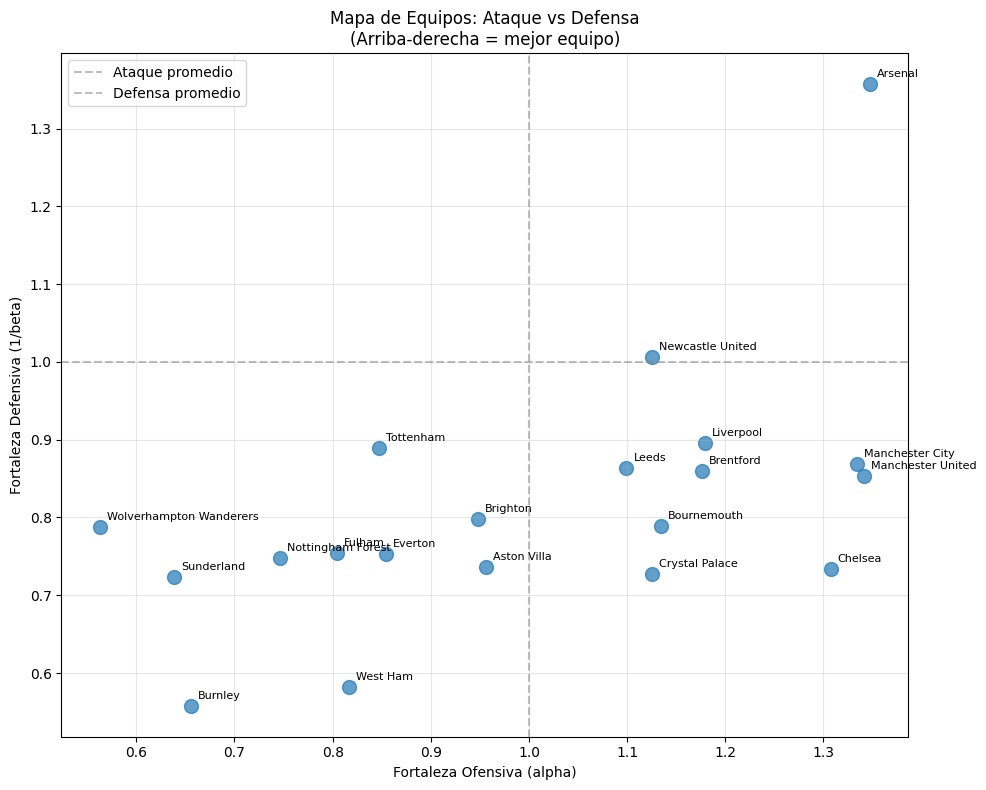

In [ ]:
# Scatter: Ataque vs Defensa
params_df = model["params_df"].copy()

fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(params_df["alpha_attack"], 1/params_df["beta_defense"], s=100, alpha=0.7)

for _, row in params_df.iterrows():
    ax.annotate(row["team"], 
                (row["alpha_attack"], 1/row["beta_defense"]),
                xytext=(5, 5), textcoords="offset points", fontsize=8)

ax.axvline(x=1, color="gray", linestyle="--", alpha=0.5, label="Ataque promedio")
ax.axhline(y=1, color="gray", linestyle="--", alpha=0.5, label="Defensa promedio")

ax.set_xlabel("Fortaleza Ofensiva (alpha)")
ax.set_ylabel("Fortaleza Defensiva (1/beta)")
ax.set_title("Mapa de Equipos: Ataque vs Defensa\n(Arriba-derecha = mejor equipo)")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Rankings Top 5
params_df = model["params_df"].copy()

top_attack = params_df.nlargest(5, "alpha_attack")[["team", "alpha_attack"]]
top_attack.columns = ["Equipo", "Ataque (alpha)"]

top_defense = params_df.nsmallest(5, "beta_defense")[["team", "beta_defense"]]
top_defense.columns = ["Equipo", "Defensa (beta)"]

print("TOP 5 ATAQUES (mayor alpha = mas goles esperados)")
print(top_attack.to_string(index=False))
print("\nTOP 5 DEFENSAS (menor beta = menos goles recibidos)")
print(top_defense.to_string(index=False))

TOP 5 ATAQUES (mayor alpha = mas goles esperados)
           Equipo  Ataque (alpha)
          Arsenal        1.347015
Manchester United        1.340940
  Manchester City        1.334532
          Chelsea        1.307242
        Liverpool        1.178884

TOP 5 DEFENSAS (menor beta = menos goles recibidos)
          Equipo  Defensa (beta)
         Arsenal        0.736833
Newcastle United        0.993931
       Liverpool        1.115700
       Tottenham        1.124865
 Manchester City        1.150897


In [ ]:
def predecir_partido(local: str, visitante: str):
    """
    Funcion interactiva para predecir cualquier partido.
    
    Uso:
        predecir_partido("Liverpool", "Manchester City")
    """
    try:
        pred = predict_match(local, visitante, model)
        
        print(f"\n{'='*50}")
        print(f"{local} vs {visitante}")
        print(f"{'='*50}")
        print(f"\nGoles esperados (xG-based):")
        print(f"  {local}: {pred['lambda_home']:.2f}")
        print(f"  {visitante}: {pred['mu_away']:.2f}")
        print(f"\nProbabilidades 1X2:")
        print(f"  1 (Local):   {pred['p_home']*100:5.1f}%")
        print(f"  X (Empate):  {pred['p_draw']*100:5.1f}%")
        print(f"  2 (Visita): {pred['p_away']*100:5.1f}%")
        
        matrix = pred["score_matrix"]
        max_idx = np.unravel_index(matrix.argmax(), matrix.shape)
        print(f"\nMarcador mas probable: {max_idx[0]}-{max_idx[1]} ({matrix[max_idx]*100:.1f}%)")
        
        plot_score_heatmap(pred)
        
    except ValueError as e:
        print(f"Error: {e}")
        print(f"\nEquipos disponibles:")
        for t in sorted(model["teams"]):
            print(f"  - {t}")

print("Equipos disponibles para prediccion:")
for i, t in enumerate(sorted(model["teams"])):
    print(f"  {i+1:2d}. {t}")

Equipos disponibles para prediccion:
   1. Arsenal
   2. Aston Villa
   3. Bournemouth
   4. Brentford
   5. Brighton
   6. Burnley
   7. Chelsea
   8. Crystal Palace
   9. Everton
  10. Fulham
  11. Leeds
  12. Liverpool
  13. Manchester City
  14. Manchester United
  15. Newcastle United
  16. Nottingham Forest
  17. Sunderland
  18. Tottenham
  19. West Ham
  20. Wolverhampton Wanderers



Tottenham vs Manchester City

Goles esperados (xG-based):
  Tottenham: 1.19
  Manchester City: 1.50

Probabilidades 1X2:
  1 (Local):    27.8%
  X (Empate):   29.9%
  2 (Visita):  42.3%

Marcador mas probable: 1-1 (14.3%)


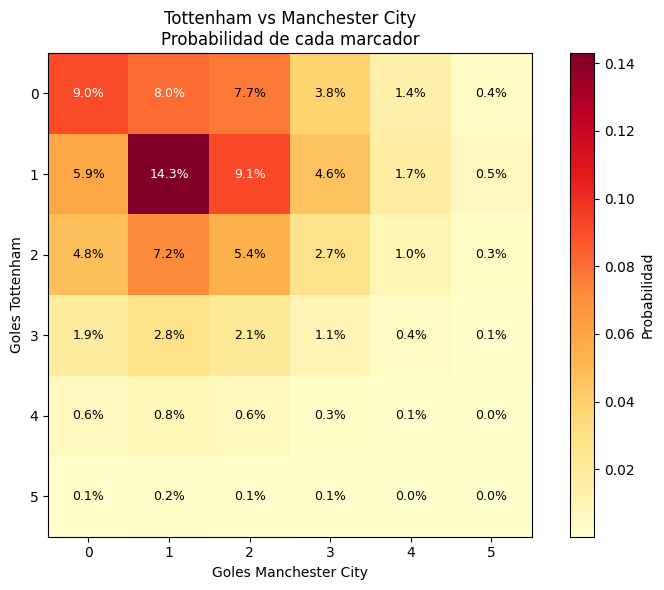

In [ ]:
# Ejemplo de uso interactivo
predecir_partido("Tottenham", "Manchester City")

## 6. Validacion del Modelo

Metricas de calibracion para evaluar la calidad de las predicciones probabilisticas:

- **Log Loss**: Penaliza fuertemente las predicciones confiadas pero incorrectas
- **Brier Score**: Error cuadratico medio de las probabilidades (menor = mejor)
- **Calibracion**: Las probabilidades predichas deben coincidir con las frecuencias observadas

In [ ]:
def evaluate_model(model, raw_matches):
    """
    Evalua el modelo con metricas de calibracion sobre partidos jugados.
    
    Returns:
        dict con log_loss, brier_score y datos de calibracion
    """
    teams = model["teams"]
    team_idx = {team: i for i, team in enumerate(teams)}
    
    results = []
    for m in raw_matches:
        if not m.get("isResult"):
            continue
        home_team = m.get("h", {}).get("title")
        away_team = m.get("a", {}).get("title")
        if home_team not in team_idx or away_team not in team_idx:
            continue
        
        home_goals = int(m.get("goals", {}).get("h", 0))
        away_goals = int(m.get("goals", {}).get("a", 0))
        
        # Resultado real: 0=away, 1=draw, 2=home
        if home_goals > away_goals:
            outcome = 2  # Home win
        elif home_goals < away_goals:
            outcome = 0  # Away win
        else:
            outcome = 1  # Draw
        
        # Prediccion del modelo
        try:
            pred = predict_match(home_team, away_team, model)
            results.append({
                "home_team": home_team,
                "away_team": away_team,
                "outcome": outcome,
                "p_home": pred["p_home"],
                "p_draw": pred["p_draw"],
                "p_away": pred["p_away"]
            })
        except:
            continue
    
    if not results:
        print("No hay partidos para evaluar")
        return None
    
    df = pd.DataFrame(results)
    
    # Log Loss (multiclass)
    eps = 1e-10
    log_loss_val = 0.0
    for _, row in df.iterrows():
        probs = [row["p_away"], row["p_draw"], row["p_home"]]
        probs = np.clip(probs, eps, 1 - eps)
        probs = probs / np.sum(probs)  # Renormalizar
        log_loss_val -= np.log(probs[row["outcome"]])
    log_loss_val /= len(df)
    
    # Brier Score (multiclass)
    brier_score = 0.0
    for _, row in df.iterrows():
        probs = np.array([row["p_away"], row["p_draw"], row["p_home"]])
        true_vec = np.zeros(3)
        true_vec[row["outcome"]] = 1
        brier_score += np.sum((probs - true_vec) ** 2)
    brier_score /= len(df)
    
    # Accuracy (marcador mas probable)
    correct = 0
    for _, row in df.iterrows():
        probs = [row["p_away"], row["p_draw"], row["p_home"]]
        pred_outcome = np.argmax(probs)
        if pred_outcome == row["outcome"]:
            correct += 1
    accuracy = correct / len(df)
    
    print("METRICAS DE VALIDACION")
    print("=" * 50)
    print(f"Partidos evaluados: {len(df)}")
    print(f"\nLog Loss: {log_loss_val:.4f}")
    print(f"  (Benchmark aleatorio: {-np.log(1/3):.4f})")
    print(f"  (Menor = mejor)")
    print(f"\nBrier Score: {brier_score:.4f}")
    print(f"  (Benchmark aleatorio: 0.667)")
    print(f"  (Menor = mejor)")
    print(f"\nAccuracy: {accuracy:.1%}")
    print(f"  (Benchmark aleatorio: 33.3%)")
    
    return {
        "log_loss": log_loss_val,
        "brier_score": brier_score,
        "accuracy": accuracy,
        "n_matches": len(df),
        "data": df
    }

validation = evaluate_model(model, raw_matches)

METRICAS DE VALIDACION
Partidos evaluados: 230

Log Loss: 1.0143
  (Benchmark aleatorio: 1.0986)
  (Menor = mejor)

Brier Score: 0.6100
  (Benchmark aleatorio: 0.667)
  (Menor = mejor)

Accuracy: 47.8%
  (Benchmark aleatorio: 33.3%)


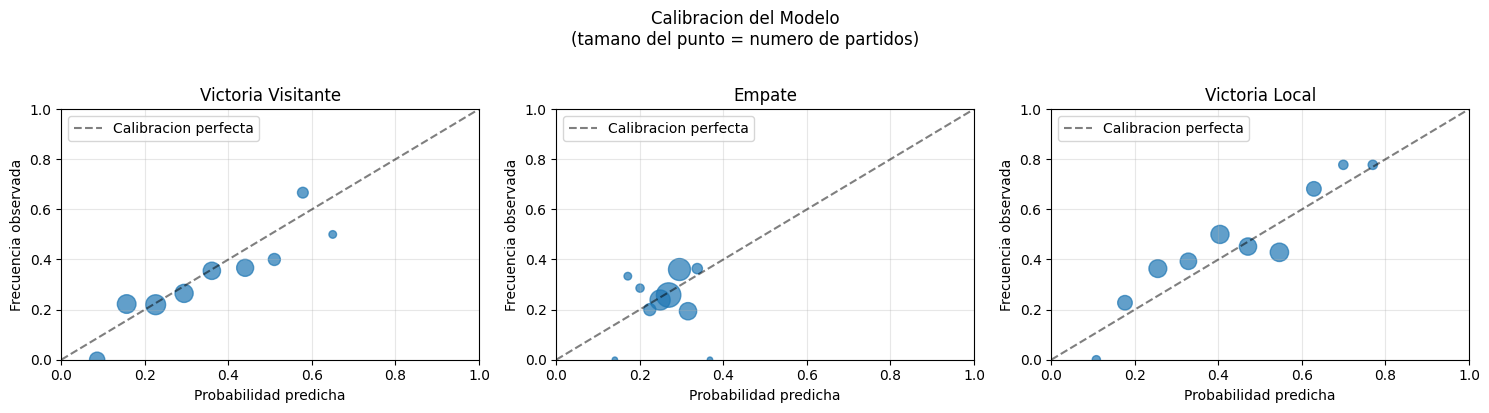

In [ ]:
def plot_calibration(validation_data, n_bins=10):
    """
    Grafico de calibracion: probabilidad predicha vs frecuencia observada.
    Una linea diagonal perfecta indica calibracion optima.
    """
    if validation_data is None:
        print("No hay datos de validacion")
        return
    
    df = validation_data["data"]
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    outcomes = ["p_away", "p_draw", "p_home"]
    labels = ["Victoria Visitante", "Empate", "Victoria Local"]
    outcome_idx = [0, 1, 2]
    
    for ax, prob_col, label, oidx in zip(axes, outcomes, labels, outcome_idx):
        # Crear bins de probabilidad
        df["bin"] = pd.cut(df[prob_col], bins=n_bins, labels=False)
        
        calibration = df.groupby("bin").agg(
            mean_pred=(prob_col, "mean"),
            freq_obs=("outcome", lambda x: (x == oidx).mean()),
            count=("outcome", "size")
        ).dropna()
        
        # Solo mostrar bins con suficientes muestras
        calibration = calibration[calibration["count"] >= 3]
        
        if len(calibration) > 0:
            ax.scatter(calibration["mean_pred"], calibration["freq_obs"], 
                      s=calibration["count"]*5, alpha=0.7)
            ax.plot([0, 1], [0, 1], "k--", alpha=0.5, label="Calibracion perfecta")
            ax.set_xlabel("Probabilidad predicha")
            ax.set_ylabel("Frecuencia observada")
            ax.set_title(label)
            ax.set_xlim(0, 1)
            ax.set_ylim(0, 1)
            ax.legend()
            ax.grid(True, alpha=0.3)
    
    plt.suptitle("Calibracion del Modelo\n(tamano del punto = numero de partidos)", y=1.02)
    plt.tight_layout()
    plt.show()

if validation:
    plot_calibration(validation)

## 7. Simulacion Monte Carlo y Value Betting

La simulacion Monte Carlo genera miles de partidos virtuales para:
- Obtener distribuciones de probabilidad mas robustas
- Calcular intervalos de confianza
- Identificar apuestas con valor esperado positivo (value bets)

In [ ]:
def simulate_match_monte_carlo(home_team, away_team, model, n_sim=10000):
    """
    Simula un partido n_sim veces usando Poisson.
    
    Returns:
        dict con probabilidades simuladas e intervalos de confianza
    """
    teams = model["teams"]
    team_idx = {team: i for i, team in enumerate(teams)}
    
    home_i = team_idx[home_team]
    away_i = team_idx[away_team]
    
    # Goles esperados
    lambda_home = model["alphas"][home_i] * model["betas"][away_i] * model["gamma"]
    mu_away = model["alphas"][away_i] * model["betas"][home_i]
    
    # Simular partidos
    home_goals = np.random.poisson(lambda_home, size=n_sim)
    away_goals = np.random.poisson(mu_away, size=n_sim)
    
    # Calcular resultados
    home_wins = np.sum(home_goals > away_goals)
    draws = np.sum(home_goals == away_goals)
    away_wins = np.sum(home_goals < away_goals)
    
    # Probabilidades
    p_home = home_wins / n_sim
    p_draw = draws / n_sim
    p_away = away_wins / n_sim
    
    # Total de goles
    total_goals = home_goals + away_goals
    
    return {
        "home_team": home_team,
        "away_team": away_team,
        "lambda_home": lambda_home,
        "mu_away": mu_away,
        "p_home": p_home,
        "p_draw": p_draw,
        "p_away": p_away,
        "mean_total_goals": np.mean(total_goals),
        "std_total_goals": np.std(total_goals),
        "p_over_2_5": np.mean(total_goals > 2.5),
        "p_over_1_5": np.mean(total_goals > 1.5),
        "p_btts": np.mean((home_goals > 0) & (away_goals > 0)),  # Both teams to score
        "home_goals_sim": home_goals,
        "away_goals_sim": away_goals
    }


def kelly_fraction(prob, odds, fraction=0.25):
    """
    Calcula la fraccion de Kelly para una apuesta.
    
    Args:
        prob: Probabilidad estimada por el modelo
        odds: Cuota decimal de la casa de apuestas
        fraction: Fraccion de Kelly (0.25 = Kelly/4, mas conservador)
    
    Returns:
        Fraccion del bankroll a apostar (0 si no hay valor)
    """
    # Probabilidad implicita de la casa
    implied_prob = 1 / odds
    
    # Value = prob_modelo - prob_implicita
    value = prob - implied_prob
    
    if value <= 0:
        return 0.0  # No hay valor
    
    # Kelly: f* = (bp - q) / b donde b = odds - 1, p = prob, q = 1 - prob
    b = odds - 1
    f_kelly = (b * prob - (1 - prob)) / b
    
    # Aplicar fraccion conservadora
    return max(0, f_kelly * fraction)


def find_value_bets(home_team, away_team, model, odds_home, odds_draw, odds_away):
    """
    Identifica apuestas con valor positivo.
    
    Args:
        odds_home, odds_draw, odds_away: Cuotas decimales de la casa
    
    Returns:
        DataFrame con analisis de valor
    """
    pred = predict_match(home_team, away_team, model)
    
    bets = []
    outcomes = [
        ("1 (Local)", pred["p_home"], odds_home),
        ("X (Empate)", pred["p_draw"], odds_draw),
        ("2 (Visita)", pred["p_away"], odds_away)
    ]
    
    for name, prob, odds in outcomes:
        implied = 1 / odds
        value = prob - implied
        ev = prob * (odds - 1) - (1 - prob)  # Expected value per unit
        kelly = kelly_fraction(prob, odds)
        
        bets.append({
            "Apuesta": name,
            "Prob Modelo": f"{prob:.1%}",
            "Prob Implicita": f"{implied:.1%}",
            "Value": f"{value:+.1%}",
            "EV (por unidad)": f"{ev:+.3f}",
            "Kelly (25%)": f"{kelly:.1%}" if kelly > 0 else "-"
        })
    
    df = pd.DataFrame(bets)
    
    print(f"\n{home_team} vs {away_team}")
    print("=" * 60)
    print(df.to_string(index=False))
    
    # Resumen
    value_bets = [b for b in bets if float(b["Value"].replace("%", "").replace("+", "")) > 0]
    if value_bets:
        print(f"\n✓ Value bets encontradas: {len(value_bets)}")
    else:
        print(f"\n✗ No hay value bets con estas cuotas")
    
    return df


# Ejemplo de simulacion Monte Carlo
HOME = "Tottenham"
AWAY = "Manchester City"

print(f"SIMULACION MONTE CARLO: {HOME} vs {AWAY}")
print("=" * 50)

sim = simulate_match_monte_carlo(HOME, AWAY, model, n_sim=50000)

print(f"\nGoles esperados:")
print(f"  {HOME}: {sim['lambda_home']:.2f}")
print(f"  {AWAY}: {sim['mu_away']:.2f}")

print(f"\nProbabilidades 1X2 (simuladas):")
print(f"  1 (Local):  {sim['p_home']:.1%}")
print(f"  X (Empate): {sim['p_draw']:.1%}")
print(f"  2 (Visita): {sim['p_away']:.1%}")

print(f"\nMercados adicionales:")
print(f"  Over 2.5: {sim['p_over_2_5']:.1%}")
print(f"  Over 1.5: {sim['p_over_1_5']:.1%}")
print(f"  BTTS (Ambos marcan): {sim['p_btts']:.1%}")
print(f"  Media goles totales: {sim['mean_total_goals']:.2f} +/- {sim['std_total_goals']:.2f}")

SIMULACION MONTE CARLO: Tottenham vs Manchester City

Goles esperados:
  Tottenham: 1.19
  Manchester City: 1.50

Probabilidades 1X2 (simuladas):
  1 (Local):  30.1%
  X (Empate): 25.6%
  2 (Visita): 44.3%

Mercados adicionales:
  Over 2.5: 50.4%
  Over 1.5: 75.3%
  BTTS (Ambos marcan): 54.3%
  Media goles totales: 2.70 +/- 1.64


In [ ]:
# Ejemplo de analisis de value bets
# Cuotas de ejemplo (sustituir por cuotas reales de una casa de apuestas)
print("\nANALISIS DE VALUE BETS")
print("(Ejemplo con cuotas ficticias - usar cuotas reales para aplicar)")

find_value_bets("Tottenham", "Manchester City", model, 
                odds_home=4.75,   # Cuota victoria local
                odds_draw=4,   # Cuota empate
                odds_away=1.60)   # Cuota victoria visitante


ANALISIS DE VALUE BETS
(Ejemplo con cuotas ficticias - usar cuotas reales para aplicar)

Tottenham vs Manchester City
   Apuesta Prob Modelo Prob Implicita  Value EV (por unidad) Kelly (25%)
 1 (Local)       27.8%          21.1%  +6.8%          +0.321        2.1%
X (Empate)       29.9%          25.0%  +4.9%          +0.195        1.6%
2 (Visita)       42.3%          62.5% -20.2%          -0.323           -

✓ Value bets encontradas: 2


,Apuesta,Prob Modelo,Prob Implicita,Value,EV (por unidad),Kelly (25%)
0,1 (Local),27.8%,21.1%,+6.8%,+0.321,2.1%
1,X (Empate),29.9%,25.0%,+4.9%,+0.195,1.6%
2,2 (Visita),42.3%,62.5%,-20.2%,-0.323,-


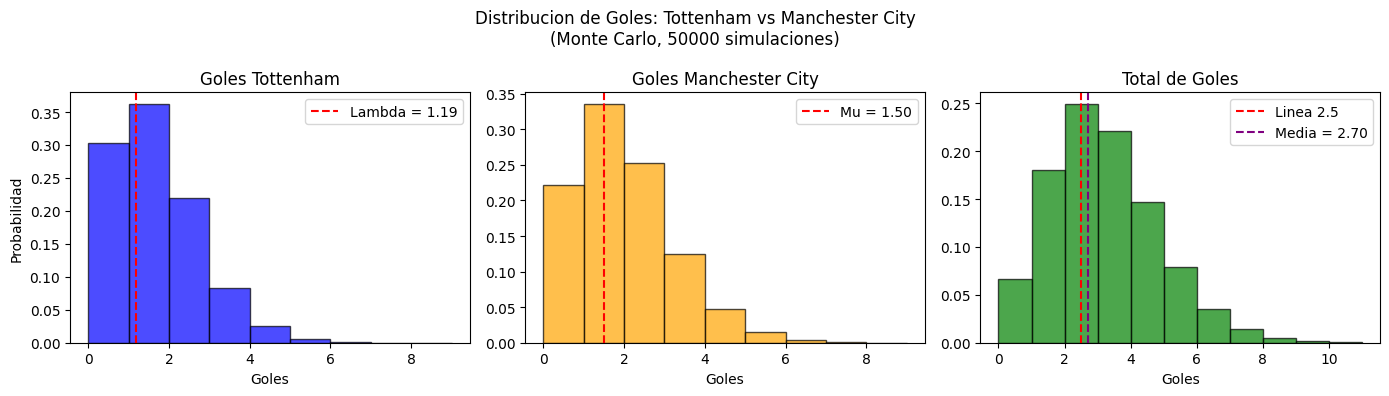

In [ ]:
# Visualizacion de la distribucion de goles (Monte Carlo)
def plot_goals_distribution(sim):
    """Histograma de goles simulados."""
    fig, axes = plt.subplots(1, 3, figsize=(14, 4))
    
    # Goles local
    axes[0].hist(sim["home_goals_sim"], bins=range(0, 10), density=True, 
                 alpha=0.7, color="blue", edgecolor="black")
    axes[0].axvline(sim["lambda_home"], color="red", linestyle="--", 
                    label=f"Lambda = {sim['lambda_home']:.2f}")
    axes[0].set_xlabel("Goles")
    axes[0].set_ylabel("Probabilidad")
    axes[0].set_title(f"Goles {sim['home_team']}")
    axes[0].legend()
    
    # Goles visitante
    axes[1].hist(sim["away_goals_sim"], bins=range(0, 10), density=True,
                 alpha=0.7, color="orange", edgecolor="black")
    axes[1].axvline(sim["mu_away"], color="red", linestyle="--",
                    label=f"Mu = {sim['mu_away']:.2f}")
    axes[1].set_xlabel("Goles")
    axes[1].set_title(f"Goles {sim['away_team']}")
    axes[1].legend()
    
    # Total de goles
    total = sim["home_goals_sim"] + sim["away_goals_sim"]
    axes[2].hist(total, bins=range(0, 12), density=True,
                 alpha=0.7, color="green", edgecolor="black")
    axes[2].axvline(2.5, color="red", linestyle="--", label="Linea 2.5")
    axes[2].axvline(sim["mean_total_goals"], color="purple", linestyle="--",
                    label=f"Media = {sim['mean_total_goals']:.2f}")
    axes[2].set_xlabel("Goles")
    axes[2].set_title("Total de Goles")
    axes[2].legend()
    
    plt.suptitle(f"Distribucion de Goles: {sim['home_team']} vs {sim['away_team']}\n(Monte Carlo, 50000 simulaciones)")
    plt.tight_layout()
    plt.show()

plot_goals_distribution(sim)

## 11. Validación Temporal Out-of-Sample (Opcional)

⚠️ **Esta sección tarda ~14 minutos** porque re-entrena el modelo múltiples veces con ventanas deslizantes.

Sáltala si solo quieres generar predicciones. Ejecútala cuando quieras validar el rendimiento histórico del modelo.

---

Esta es la prueba definitiva: ¿el modelo puede predecir partidos que **nunca vio**?

### Metodología
1. Ordenamos partidos por fecha
2. Entrenamos SOLO con partidos antiguos
3. Predecimos partidos futuros (que el modelo nunca vio)
4. Comparamos predicciones vs resultados reales

Esto simula el uso real del modelo.

In [131]:
# Construir DataFrame de partidos con fechas
def build_matches_with_dates(raw_matches, df_shots):
    """
    Combina datos de partidos (fechas, goles) con xG calculado.
    """
    matches = []
    for m in raw_matches:
        if not m.get("isResult"):
            continue
        
        match_id = str(m.get("id"))
        home_team = m.get("h", {}).get("title")
        away_team = m.get("a", {}).get("title")
        
        if not home_team or not away_team:
            continue
        
        # Fecha del partido
        datetime_str = m.get("datetime", "")
        
        matches.append({
            "match_id": match_id,
            "datetime": datetime_str,
            "home_team": home_team,
            "away_team": away_team,
            "home_goals": int(m.get("goals", {}).get("h", 0)),
            "away_goals": int(m.get("goals", {}).get("a", 0))
        })
    
    df_matches = pd.DataFrame(matches)
    df_matches["datetime"] = pd.to_datetime(df_matches["datetime"])
    df_matches = df_matches.sort_values("datetime").reset_index(drop=True)
    
    # Agregar xG desde df_shots
    xg_agg = (
        df_shots.groupby(["match_id", "team", "venue"], observed=True)
        .agg(xg=("xg", "sum"))
        .reset_index()
    )
    
    home_xg = xg_agg[xg_agg["venue"] == "home"][["match_id", "xg"]].rename(columns={"xg": "home_xg"})
    away_xg = xg_agg[xg_agg["venue"] == "away"][["match_id", "xg"]].rename(columns={"xg": "away_xg"})
    
    df_matches = df_matches.merge(home_xg, on="match_id", how="left")
    df_matches = df_matches.merge(away_xg, on="match_id", how="left")
    
    # Eliminar partidos sin xG
    df_matches = df_matches.dropna(subset=["home_xg", "away_xg"])
    
    return df_matches

# Construir dataset con fechas
df_matches = build_matches_with_dates(raw_matches, df_shots)

print(f"Partidos con fecha y xG: {len(df_matches)}")
print(f"Rango de fechas: {df_matches['datetime'].min().date()} a {df_matches['datetime'].max().date()}")
print(f"\nPrimeros 5 partidos:")
df_matches.head()

Partidos con fecha y xG: 610
Rango de fechas: 2024-08-16 a 2026-01-26

Primeros 5 partidos:


,match_id,datetime,home_team,away_team,home_goals,away_goals,home_xg,away_xg
0,26602,2024-08-16 19:00:00,Manchester United,Fulham,1,0,2.042675,0.418711
1,26603,2024-08-17 11:30:00,Ipswich,Liverpool,0,2,0.342601,3.935329
2,26604,2024-08-17 14:00:00,Arsenal,Wolverhampton Wanderers,2,0,1.628303,0.509324
3,26605,2024-08-17 14:00:00,Everton,Brighton,0,3,0.405908,1.790827
4,26606,2024-08-17 14:00:00,Newcastle United,Southampton,1,0,0.433489,2.104293


In [ ]:
# ⚠️ SKIP FLAG - Cambia a False para ejecutar la validación (tarda ~14 min)
SKIP_TEMPORAL_VALIDATION = True

def temporal_validation(df_matches, train_ratio=0.7, reg=0.001):
    """
    Validación temporal: entrena con partidos antiguos, evalúa con recientes.
    
    Args:
        df_matches: DataFrame con columnas [datetime, home_team, away_team, 
                    home_xg, away_xg, home_goals, away_goals]
        train_ratio: Proporción de partidos para entrenamiento (0.7 = 70%)
        reg: Regularización L2
    
    Returns:
        dict con métricas in-sample y out-of-sample
    """
    # Ordenar por fecha
    df = df_matches.sort_values("datetime").reset_index(drop=True)
    
    # Split temporal
    n_train = int(len(df) * train_ratio)
    train_df = df.iloc[:n_train].copy()
    test_df = df.iloc[n_train:].copy()
    
    cutoff_date = train_df["datetime"].max()
    
    print("=" * 60)
    print("VALIDACIÓN TEMPORAL (OUT-OF-SAMPLE)")
    print("=" * 60)
    print(f"\nCutoff: {cutoff_date.date()}")
    print(f"TRAIN: {len(train_df)} partidos ({train_df['datetime'].min().date()} → {train_df['datetime'].max().date()})")
    print(f"TEST:  {len(test_df)} partidos ({test_df['datetime'].min().date()} → {test_df['datetime'].max().date()})")
    
    # Verificar que todos los equipos del test están en train
    train_teams = set(train_df["home_team"]) | set(train_df["away_team"])
    test_teams = set(test_df["home_team"]) | set(test_df["away_team"])
    missing_teams = test_teams - train_teams
    
    if missing_teams:
        print(f"\n⚠ Equipos en TEST sin datos en TRAIN: {missing_teams}")
        test_df = test_df[
            test_df["home_team"].isin(train_teams) & 
            test_df["away_team"].isin(train_teams)
        ]
        print(f"  Partidos TEST después de filtrar: {len(test_df)}")
    
    # Preparar datos para entrenar (formato match_xg)
    train_xg = train_df[["match_id", "home_team", "away_team", "home_xg", "away_xg"]].copy()
    
    # Entrenar modelo SOLO con datos de train
    print(f"\nEntrenando modelo con {len(train_xg)} partidos...")
    
    # Silenciar output del fit
    import io, sys
    old_stdout = sys.stdout
    sys.stdout = io.StringIO()
    
    # Crear raw_matches falso solo con partidos de train (para estimar rho)
    train_match_ids = set(train_df["match_id"])
    train_raw = [m for m in raw_matches if str(m.get("id")) in train_match_ids]
    
    model_train = fit_dixon_coles_xg(train_xg, raw_matches=train_raw, reg=reg)
    sys.stdout = old_stdout
    
    print(f"✓ Modelo entrenado (gamma={model_train['gamma']:.3f}, rho={model_train['rho']:.4f})")
    
    # Función para evaluar en un conjunto de partidos
    def evaluate_on_matches(model, matches_df, set_name):
        eps = 1e-10
        log_loss = 0.0
        brier = 0.0
        correct = 0
        n = 0
        
        predictions = []
        
        for _, row in matches_df.iterrows():
            ht, at = row["home_team"], row["away_team"]
            hg, ag = row["home_goals"], row["away_goals"]
            
            # Resultado real: 0=away, 1=draw, 2=home
            if hg > ag:
                outcome = 2
            elif hg < ag:
                outcome = 0
            else:
                outcome = 1
            
            try:
                pred = predict_match(ht, at, model)
                probs = np.array([pred["p_away"], pred["p_draw"], pred["p_home"]])
                probs = np.clip(probs, eps, 1 - eps)
                probs = probs / probs.sum()
                
                # Log Loss
                log_loss -= np.log(probs[outcome])
                
                # Brier Score
                true_vec = np.zeros(3)
                true_vec[outcome] = 1
                brier += np.sum((probs - true_vec) ** 2)
                
                # Accuracy
                if np.argmax(probs) == outcome:
                    correct += 1
                
                predictions.append({
                    "home": ht, "away": at,
                    "p_home": pred["p_home"], "p_draw": pred["p_draw"], "p_away": pred["p_away"],
                    "outcome": outcome, "correct": np.argmax(probs) == outcome
                })
                
                n += 1
            except Exception as e:
                continue
        
        if n == 0:
            return None
        
        return {
            "set": set_name,
            "n": n,
            "log_loss": log_loss / n,
            "brier": brier / n,
            "accuracy": correct / n,
            "predictions": predictions
        }
    
    # Evaluar en TRAIN (in-sample)
    results_train = evaluate_on_matches(model_train, train_df, "TRAIN (in-sample)")
    
    # Evaluar en TEST (out-of-sample)
    results_test = evaluate_on_matches(model_train, test_df, "TEST (out-of-sample)")
    
    # Benchmarks
    benchmark_log_loss = -np.log(1/3)  # 1.0986
    benchmark_brier = 2/3  # 0.667
    benchmark_acc = 1/3  # 0.333
    
    # Mostrar resultados
    print(f"\n{'='*60}")
    print("RESULTADOS")
    print(f"{'='*60}")
    print(f"\n{'Métrica':<20} {'TRAIN':<15} {'TEST (OOS)':<15} {'Benchmark':<15}")
    print("-" * 60)
    
    if results_train and results_test:
        print(f"{'Log Loss':<20} {results_train['log_loss']:<15.4f} {results_test['log_loss']:<15.4f} {benchmark_log_loss:<15.4f}")
        print(f"{'Brier Score':<20} {results_train['brier']:<15.4f} {results_test['brier']:<15.4f} {benchmark_brier:<15.4f}")
        print(f"{'Accuracy':<20} {results_train['accuracy']*100:<14.1f}% {results_test['accuracy']*100:<14.1f}% {benchmark_acc*100:<14.1f}%")
        print(f"{'N partidos':<20} {results_train['n']:<15} {results_test['n']:<15}")
        
        # Interpretación
        print(f"\n{'='*60}")
        print("INTERPRETACIÓN")
        print(f"{'='*60}")
        
        oos_ll = results_test['log_loss']
        if oos_ll < benchmark_log_loss:
            edge_ll = (benchmark_log_loss - oos_ll) / benchmark_log_loss * 100
            print(f"\n✓ Log Loss OOS ({oos_ll:.4f}) < Benchmark ({benchmark_log_loss:.4f})")
            print(f"  El modelo tiene {edge_ll:.1f}% mejor capacidad predictiva que el azar")
        else:
            print(f"\n✗ Log Loss OOS ({oos_ll:.4f}) >= Benchmark ({benchmark_log_loss:.4f})")
            print(f"  El modelo NO supera al azar en predicciones out-of-sample")
        
        # Overfitting check
        overfit = results_test['log_loss'] - results_train['log_loss']
        print(f"\nOverfitting check:")
        print(f"  Diferencia Log Loss (TEST - TRAIN): {overfit:+.4f}")
        if overfit > 0.1:
            print(f"  ⚠ Alta diferencia sugiere overfitting")
        else:
            print(f"  ✓ Diferencia aceptable")
    
    return {
        "model": model_train,
        "train": results_train,
        "test": results_test,
        "train_df": train_df,
        "test_df": test_df,
        "cutoff_date": cutoff_date
    }

# Ejecutar validación temporal (solo si no está en modo SKIP)
if not SKIP_TEMPORAL_VALIDATION:
    val_results = temporal_validation(df_matches, train_ratio=0.7, reg=0.001)
else:
    print("⏭️ Validación temporal SALTADA (SKIP_TEMPORAL_VALIDATION = True)")
    print("   Cambia a False en la línea 2 para ejecutar (~14 min)")
    val_results = None

In [ ]:
# Validación con ventana deslizante (más robusta)
def rolling_validation(df_matches, min_train_matches=100, step_matches=10, reg=0.001):
    """
    Validación con ventana deslizante: simula el uso real del modelo.
    
    En cada paso:
    1. Entrena con todos los partidos hasta fecha X
    2. Predice los siguientes `step_matches` partidos
    3. Avanza la ventana y repite
    
    Esto es más realista porque:
    - El modelo se re-entrena periódicamente (como harías en la práctica)
    - Evalúa en múltiples puntos temporales (no solo un split)
    """
    df = df_matches.sort_values("datetime").reset_index(drop=True)
    
    print("=" * 60)
    print("VALIDACIÓN CON VENTANA DESLIZANTE")
    print("=" * 60)
    print(f"Partidos totales: {len(df)}")
    print(f"Mínimo para entrenar: {min_train_matches}")
    print(f"Paso de evaluación: {step_matches} partidos")
    
    all_predictions = []
    n_windows = 0
    
    # Empezar después de tener suficientes partidos para entrenar
    for start_test in range(min_train_matches, len(df), step_matches):
        end_test = min(start_test + step_matches, len(df))
        
        train_df = df.iloc[:start_test].copy()
        test_df = df.iloc[start_test:end_test].copy()
        
        if len(test_df) == 0:
            break
        
        # Verificar equipos
        train_teams = set(train_df["home_team"]) | set(train_df["away_team"])
        test_df = test_df[
            test_df["home_team"].isin(train_teams) & 
            test_df["away_team"].isin(train_teams)
        ]
        
        if len(test_df) == 0:
            continue
        
        # Entrenar modelo (silencioso)
        train_xg = train_df[["match_id", "home_team", "away_team", "home_xg", "away_xg"]]
        train_match_ids = set(train_df["match_id"])
        train_raw = [m for m in raw_matches if str(m.get("id")) in train_match_ids]
        
        import io, sys
        old_stdout = sys.stdout
        sys.stdout = io.StringIO()
        model_window = fit_dixon_coles_xg(train_xg, raw_matches=train_raw, reg=reg)
        sys.stdout = old_stdout
        
        # Evaluar en test
        for _, row in test_df.iterrows():
            ht, at = row["home_team"], row["away_team"]
            hg, ag = row["home_goals"], row["away_goals"]
            
            if hg > ag:
                outcome = 2
            elif hg < ag:
                outcome = 0
            else:
                outcome = 1
            
            try:
                pred = predict_match(ht, at, model_window)
                all_predictions.append({
                    "window": n_windows,
                    "date": row["datetime"],
                    "home": ht,
                    "away": at,
                    "p_home": pred["p_home"],
                    "p_draw": pred["p_draw"],
                    "p_away": pred["p_away"],
                    "outcome": outcome,
                    "train_size": len(train_df)
                })
            except:
                continue
        
        n_windows += 1
    
    if not all_predictions:
        print("No hay suficientes datos para validación rolling")
        return None
    
    pred_df = pd.DataFrame(all_predictions)
    
    # Calcular métricas globales
    eps = 1e-10
    total_ll = 0.0
    total_brier = 0.0
    correct = 0
    
    for _, row in pred_df.iterrows():
        probs = np.array([row["p_away"], row["p_draw"], row["p_home"]])
        probs = np.clip(probs, eps, 1 - eps)
        probs = probs / probs.sum()
        
        outcome = row["outcome"]
        
        total_ll -= np.log(probs[outcome])
        
        true_vec = np.zeros(3)
        true_vec[outcome] = 1
        total_brier += np.sum((probs - true_vec) ** 2)
        
        if np.argmax(probs) == outcome:
            correct += 1
    
    n = len(pred_df)
    log_loss = total_ll / n
    brier = total_brier / n
    accuracy = correct / n
    
    # Benchmarks
    benchmark_ll = -np.log(1/3)
    benchmark_brier = 2/3
    benchmark_acc = 1/3
    
    print(f"\nVentanas evaluadas: {n_windows}")
    print(f"Predicciones totales: {n}")
    print(f"\n{'='*60}")
    print("RESULTADOS ROLLING (Out-of-Sample)")
    print(f"{'='*60}")
    print(f"\n{'Métrica':<20} {'Modelo':<15} {'Benchmark':<15} {'Diferencia':<15}")
    print("-" * 60)
    print(f"{'Log Loss':<20} {log_loss:<15.4f} {benchmark_ll:<15.4f} {log_loss - benchmark_ll:<+15.4f}")
    print(f"{'Brier Score':<20} {brier:<15.4f} {benchmark_brier:<15.4f} {brier - benchmark_brier:<+15.4f}")
    print(f"{'Accuracy':<20} {accuracy*100:<14.1f}% {benchmark_acc*100:<14.1f}% {(accuracy-benchmark_acc)*100:<+14.1f}%")
    
    # Interpretación final
    print(f"\n{'='*60}")
    print("VEREDICTO FINAL")
    print(f"{'='*60}")
    
    if log_loss < benchmark_ll:
        edge = (benchmark_ll - log_loss) / benchmark_ll * 100
        print(f"\n✓ EL MODELO TIENE CAPACIDAD PREDICTIVA REAL")
        print(f"  Edge sobre azar: {edge:.1f}%")
        print(f"  Log Loss OOS: {log_loss:.4f} (mejor que {benchmark_ll:.4f})")
        
        if edge > 5:
            print(f"\n  → Potencial para apuestas (edge > 5%)")
            print(f"    PERO: aún necesitas comparar vs odds del mercado")
        else:
            print(f"\n  → Edge pequeño ({edge:.1f}%), probablemente insuficiente")
            print(f"    Las comisiones (~5%) pueden eliminarlo")
    else:
        print(f"\n✗ EL MODELO NO SUPERA AL AZAR")
        print(f"  Log Loss OOS: {log_loss:.4f} (peor que {benchmark_ll:.4f})")
        print(f"\n  → No recomendado para apuestas")
        print(f"  → Necesita mejoras (más datos, features, etc.)")
    
    return {
        "log_loss": log_loss,
        "brier": brier,
        "accuracy": accuracy,
        "n_predictions": n,
        "n_windows": n_windows,
        "predictions": pred_df
    }

# Ejecutar validación rolling (solo si no está en modo SKIP)
if not SKIP_TEMPORAL_VALIDATION:
    rolling_results = rolling_validation(df_matches, min_train_matches=100, step_matches=10)
else:
    rolling_results = None

In [ ]:
# Visualizar rendimiento rolling (solo si se ejecutó la validación)
if rolling_results is not None:
    pred_df = rolling_results["predictions"]
    
    # Calcular log loss acumulado
    pred_df = pred_df.sort_values("date").reset_index(drop=True)
    
    eps = 1e-10
    cumulative_ll = []
    running_ll = 0.0
    
    for i, row in pred_df.iterrows():
        probs = np.array([row["p_away"], row["p_draw"], row["p_home"]])
        probs = np.clip(probs, eps, 1 - eps)
        probs = probs / probs.sum()
        running_ll -= np.log(probs[row["outcome"]])
        cumulative_ll.append(running_ll / (i + 1))
    
    pred_df["cumulative_ll"] = cumulative_ll
    
    # Gráfico
    fig, ax = plt.subplots(figsize=(12, 5))
    
    ax.plot(pred_df.index, pred_df["cumulative_ll"], 'b-', lw=2, label="Modelo")
    ax.axhline(-np.log(1/3), color='red', ls='--', lw=2, label=f"Benchmark (azar): {-np.log(1/3):.4f}")
    
    ax.fill_between(pred_df.index, pred_df["cumulative_ll"], -np.log(1/3),
                    where=pred_df["cumulative_ll"] < -np.log(1/3),
                    color='green', alpha=0.3, label="Edge positivo")
    
    ax.set_xlabel("Número de predicción", fontsize=12)
    ax.set_ylabel("Log Loss acumulado", fontsize=12)
    ax.set_title("Evolución del Log Loss Out-of-Sample (Rolling Validation)", fontsize=14)
    ax.legend(loc="upper right")
    ax.grid(True, alpha=0.3)
    
    # Añadir valor final
    final_ll = cumulative_ll[-1]
    ax.annotate(f"Final: {final_ll:.4f}", 
                xy=(len(cumulative_ll)-1, final_ll),
                xytext=(len(cumulative_ll)*0.8, final_ll + 0.02),
                fontsize=10,
                arrowprops=dict(arrowstyle="->", color="blue"))
    
    plt.tight_layout()
    plt.show()
else:
    print("⏭️ Visualización saltada (rolling_results es None)")
    print("   Ejecuta la validación temporal para ver este gráfico")

## 8. Comparación vs Odds del Mercado (El Test Definitivo)

Superar al azar no es suficiente. El verdadero test es superar a las **odds de cierre del mercado**.

Las casas de apuestas tienen equipos de analistas y modelos sofisticados. Si tu modelo no supera sus odds, no hay edge real.

Usamos [football-data.co.uk](https://www.football-data.co.uk/) que proporciona odds históricas gratuitas de múltiples casas (Bet365, Pinnacle, etc.).

In [134]:
# Descargar odds históricas de football-data.co.uk
import ssl
import urllib.request
import io
import warnings

def download_odds_data(seasons=["2526", "2425"], league="E0"):
    """
    Descarga odds históricas de football-data.co.uk
    
    Args:
        seasons: Lista de temporadas (ej: "2526" = 2025-26, "2425" = 2024-25)
        league: Código de liga (E0=EPL, SP1=LaLiga, D1=Bundesliga, I1=SerieA, F1=Ligue1)
    
    Returns:
        DataFrame con partidos y odds
    """
    base_url = "https://www.football-data.co.uk/mmz4281/{season}/{league}.csv"
    
    # Crear contexto SSL que no verifica certificados
    ssl_context = ssl.create_default_context()
    ssl_context.check_hostname = False
    ssl_context.verify_mode = ssl.CERT_NONE
    
    all_data = []
    
    for season in seasons:
        url = base_url.format(season=season, league=league)
        print(f"Descargando: {url}")
        
        try:
            # Descargar con SSL sin verificar
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                req = urllib.request.Request(url, headers={'User-Agent': 'Mozilla/5.0'})
                with urllib.request.urlopen(req, context=ssl_context) as response:
                    csv_data = response.read().decode('latin-1')
            
            df = pd.read_csv(io.StringIO(csv_data))
            df["season"] = season
            all_data.append(df)
            print(f"  ✓ {len(df)} partidos")
        except urllib.error.HTTPError as e:
            print(f"  ✗ HTTP Error {e.code}: {e.reason}")
        except Exception as e:
            print(f"  ✗ Error: {e}")
    
    if not all_data:
        return None
    
    df = pd.concat(all_data, ignore_index=True)
    
    # Columnas relevantes
    cols_to_keep = [
        "Date", "HomeTeam", "AwayTeam", 
        "FTHG", "FTAG", "FTR",  # Resultado
        "B365H", "B365D", "B365A",  # Bet365
        "PSH", "PSD", "PSA",  # Pinnacle (las más eficientes)
        "season"
    ]
    
    # Filtrar columnas que existen
    cols_available = [c for c in cols_to_keep if c in df.columns]
    df = df[cols_available].copy()
    
    # Parsear fecha
    df["Date"] = pd.to_datetime(df["Date"], dayfirst=True, errors="coerce")
    df = df.dropna(subset=["Date"])
    
    return df

# Descargar datos (temporadas 2024-25 y 2025-26)
odds_df = download_odds_data(seasons=["2526", "2425"], league="E0")

if odds_df is not None:
    print(f"\nTotal partidos con odds: {len(odds_df)}")
    print(f"Rango: {odds_df['Date'].min().date()} a {odds_df['Date'].max().date()}")
    print(f"\nColumnas disponibles: {list(odds_df.columns)}")
    odds_df.head()
else:
    print("\n⚠ No se pudieron descargar las odds.")
    print("Alternativa: descarga manualmente desde https://www.football-data.co.uk/englandm.php")
    print("y carga el CSV con: odds_df = pd.read_csv('ruta/al/archivo.csv')")

In [ ]:
# Mapeo de nombres de equipos (Understat → football-data.co.uk)
# Premier League 2025-26
TEAM_NAME_MAP = {
    # Equipos con nombres diferentes
    "Manchester United": "Man United",
    "Manchester City": "Man City",
    "Newcastle United": "Newcastle",
    "Wolverhampton Wanderers": "Wolves",
    "Nottingham Forest": "Nott'm Forest",
    # Equipos con nombres iguales (no requieren mapeo, pero explícitos para referencia)
    # Arsenal, Aston Villa, Bournemouth, Brentford, Brighton, Burnley,
    # Chelsea, Crystal Palace, Everton, Fulham, Leeds, Liverpool,
    # Sunderland, Tottenham, West Ham
}

def normalize_team_name(name, reverse=False):
    """Normaliza nombres de equipos entre fuentes."""
    if reverse:
        # football-data → Understat
        reverse_map = {v: k for k, v in TEAM_NAME_MAP.items()}
        return reverse_map.get(name, name)
    else:
        # Understat → football-data
        return TEAM_NAME_MAP.get(name, name)


def backtest_vs_market(df_matches, odds_df, model, min_edge=0.03, use_pinnacle=True):
    """
    Backtesting del modelo contra odds reales del mercado.
    
    Args:
        df_matches: DataFrame con partidos y xG (de nuestro modelo)
        odds_df: DataFrame con odds históricas
        model: Modelo Dixon-Coles entrenado
        min_edge: Edge mínimo para apostar (default 3%)
        use_pinnacle: Usar Pinnacle (True) o Bet365 (False)
    
    Returns:
        dict con resultados del backtest
    """
    # Seleccionar columnas de odds
    if use_pinnacle and "PSH" in odds_df.columns:
        odds_cols = {"home": "PSH", "draw": "PSD", "away": "PSA"}
        bookmaker = "Pinnacle"
    else:
        odds_cols = {"home": "B365H", "draw": "B365D", "away": "B365A"}
        bookmaker = "Bet365"
    
    print("=" * 70)
    print(f"BACKTEST VS MERCADO ({bookmaker})")
    print("=" * 70)
    
    # Preparar datos
    results = []
    
    for _, match in df_matches.iterrows():
        home_team = match["home_team"]
        away_team = match["away_team"]
        match_date = match["datetime"].date()
        
        # Buscar odds correspondientes
        home_norm = normalize_team_name(home_team)
        away_norm = normalize_team_name(away_team)
        
        odds_match = odds_df[
            (odds_df["HomeTeam"] == home_norm) & 
            (odds_df["AwayTeam"] == away_norm) &
            (odds_df["Date"].dt.date == match_date)
        ]
        
        if odds_match.empty:
            # Intentar buscar por fecha cercana (±1 día)
            odds_match = odds_df[
                (odds_df["HomeTeam"] == home_norm) & 
                (odds_df["AwayTeam"] == away_norm) &
                (abs((odds_df["Date"].dt.date - match_date).apply(lambda x: x.days if hasattr(x, 'days') else 999)) <= 1)
            ]
        
        if odds_match.empty:
            continue
        
        odds_row = odds_match.iloc[0]
        
        # Obtener odds del mercado
        try:
            market_odds_home = float(odds_row[odds_cols["home"]])
            market_odds_draw = float(odds_row[odds_cols["draw"]])
            market_odds_away = float(odds_row[odds_cols["away"]])
        except (ValueError, KeyError):
            continue
        
        if pd.isna(market_odds_home) or pd.isna(market_odds_draw) or pd.isna(market_odds_away):
            continue
        
        # Predicción del modelo
        try:
            pred = predict_match(home_team, away_team, model)
        except:
            continue
        
        # Resultado real
        home_goals = match["home_goals"]
        away_goals = match["away_goals"]
        if home_goals > away_goals:
            result = "home"
        elif home_goals < away_goals:
            result = "away"
        else:
            result = "draw"
        
        # Calcular edge vs mercado para cada outcome
        for outcome, prob_key, odds_key in [
            ("home", "p_home", market_odds_home),
            ("draw", "p_draw", market_odds_draw),
            ("away", "p_away", market_odds_away)
        ]:
            prob_modelo = pred[prob_key]
            prob_mercado = 1 / odds_key
            edge = prob_modelo - prob_mercado
            
            results.append({
                "date": match_date,
                "home_team": home_team,
                "away_team": away_team,
                "outcome": outcome,
                "prob_modelo": prob_modelo,
                "odds_mercado": odds_key,
                "prob_mercado": prob_mercado,
                "edge": edge,
                "result": result,
                "won": result == outcome
            })
    
    if not results:
        print("No se encontraron partidos coincidentes")
        return None
    
    df_results = pd.DataFrame(results)
    
    # Estadísticas generales
    print(f"\nPartidos analizados: {len(df_results) // 3}")
    print(f"Apuestas potenciales: {len(df_results)}")
    
    # Calcular Log Loss vs mercado
    eps = 1e-10
    model_ll = 0
    market_ll = 0
    n_matches = 0
    
    for match_date in df_results["date"].unique():
        match_data = df_results[df_results["date"] == match_date].iloc[:3]  # home, draw, away
        if len(match_data) < 3:
            continue
        
        home_row = match_data[match_data["outcome"] == "home"].iloc[0]
        draw_row = match_data[match_data["outcome"] == "draw"].iloc[0]
        away_row = match_data[match_data["outcome"] == "away"].iloc[0]
        
        # Probabilidades del modelo
        probs_modelo = np.array([home_row["prob_modelo"], draw_row["prob_modelo"], away_row["prob_modelo"]])
        probs_modelo = np.clip(probs_modelo, eps, 1-eps)
        probs_modelo = probs_modelo / probs_modelo.sum()
        
        # Probabilidades del mercado (normalizadas)
        probs_mercado = np.array([home_row["prob_mercado"], draw_row["prob_mercado"], away_row["prob_mercado"]])
        probs_mercado = np.clip(probs_mercado, eps, 1-eps)
        probs_mercado = probs_mercado / probs_mercado.sum()
        
        # Resultado
        result = home_row["result"]
        outcome_idx = {"home": 0, "draw": 1, "away": 2}[result]
        
        model_ll -= np.log(probs_modelo[outcome_idx])
        market_ll -= np.log(probs_mercado[outcome_idx])
        n_matches += 1
    
    if n_matches > 0:
        model_ll /= n_matches
        market_ll /= n_matches
        
        print(f"\n{'='*70}")
        print("LOG LOSS: MODELO vs MERCADO")
        print(f"{'='*70}")
        print(f"  Modelo:   {model_ll:.4f}")
        print(f"  Mercado:  {market_ll:.4f}")
        print(f"  Benchmark (azar): {-np.log(1/3):.4f}")
        
        if model_ll < market_ll:
            edge_vs_market = (market_ll - model_ll) / market_ll * 100
            print(f"\n  ✓ Modelo SUPERA al mercado por {edge_vs_market:.2f}%")
        else:
            print(f"\n  ✗ Modelo NO supera al mercado")
            print(f"    El mercado es {(model_ll - market_ll) / model_ll * 100:.2f}% más preciso")
    
    # Simulación de apuestas con value betting
    print(f"\n{'='*70}")
    print(f"SIMULACIÓN DE VALUE BETTING (edge >= {min_edge*100:.0f}%)")
    print(f"{'='*70}")
    
    # Filtrar apuestas con edge positivo
    value_bets = df_results[df_results["edge"] >= min_edge].copy()
    
    if len(value_bets) == 0:
        print(f"\nNo hay apuestas con edge >= {min_edge*100:.0f}%")
        return {"df_results": df_results, "model_ll": model_ll, "market_ll": market_ll}
    
    # Calcular P&L
    value_bets["stake"] = 1.0  # Apuesta fija de 1 unidad
    value_bets["pnl"] = value_bets.apply(
        lambda x: x["stake"] * (x["odds_mercado"] - 1) if x["won"] else -x["stake"],
        axis=1
    )
    
    total_bets = len(value_bets)
    wins = value_bets["won"].sum()
    total_staked = value_bets["stake"].sum()
    total_pnl = value_bets["pnl"].sum()
    roi = total_pnl / total_staked * 100
    
    print(f"\nApuestas realizadas: {total_bets}")
    print(f"Victorias: {wins} ({wins/total_bets*100:.1f}%)")
    print(f"Total apostado: {total_staked:.0f} unidades")
    print(f"P&L total: {total_pnl:+.2f} unidades")
    print(f"ROI: {roi:+.2f}%")
    
    # Desglose por tipo de apuesta
    print(f"\nDesglose por mercado:")
    for outcome in ["home", "draw", "away"]:
        subset = value_bets[value_bets["outcome"] == outcome]
        if len(subset) > 0:
            pnl = subset["pnl"].sum()
            n = len(subset)
            w = subset["won"].sum()
            print(f"  {outcome:>5}: {n:3d} apuestas, {w:3d} wins ({w/n*100:5.1f}%), P&L: {pnl:+6.2f}")
    
    # Evolución del bankroll
    value_bets = value_bets.sort_values("date")
    value_bets["cumulative_pnl"] = value_bets["pnl"].cumsum()
    
    return {
        "df_results": df_results,
        "value_bets": value_bets,
        "model_ll": model_ll if n_matches > 0 else None,
        "market_ll": market_ll if n_matches > 0 else None,
        "total_bets": total_bets,
        "roi": roi,
        "total_pnl": total_pnl
    }

# Ejecutar backtest (solo si tenemos odds)
if odds_df is not None and len(odds_df) > 0:
    backtest_results = backtest_vs_market(
        df_matches, 
        odds_df, 
        model,  # Usar el modelo entrenado con todos los datos
        min_edge=0.03,
        use_pinnacle=True
    )
else:
    print("No hay datos de odds disponibles para backtest")

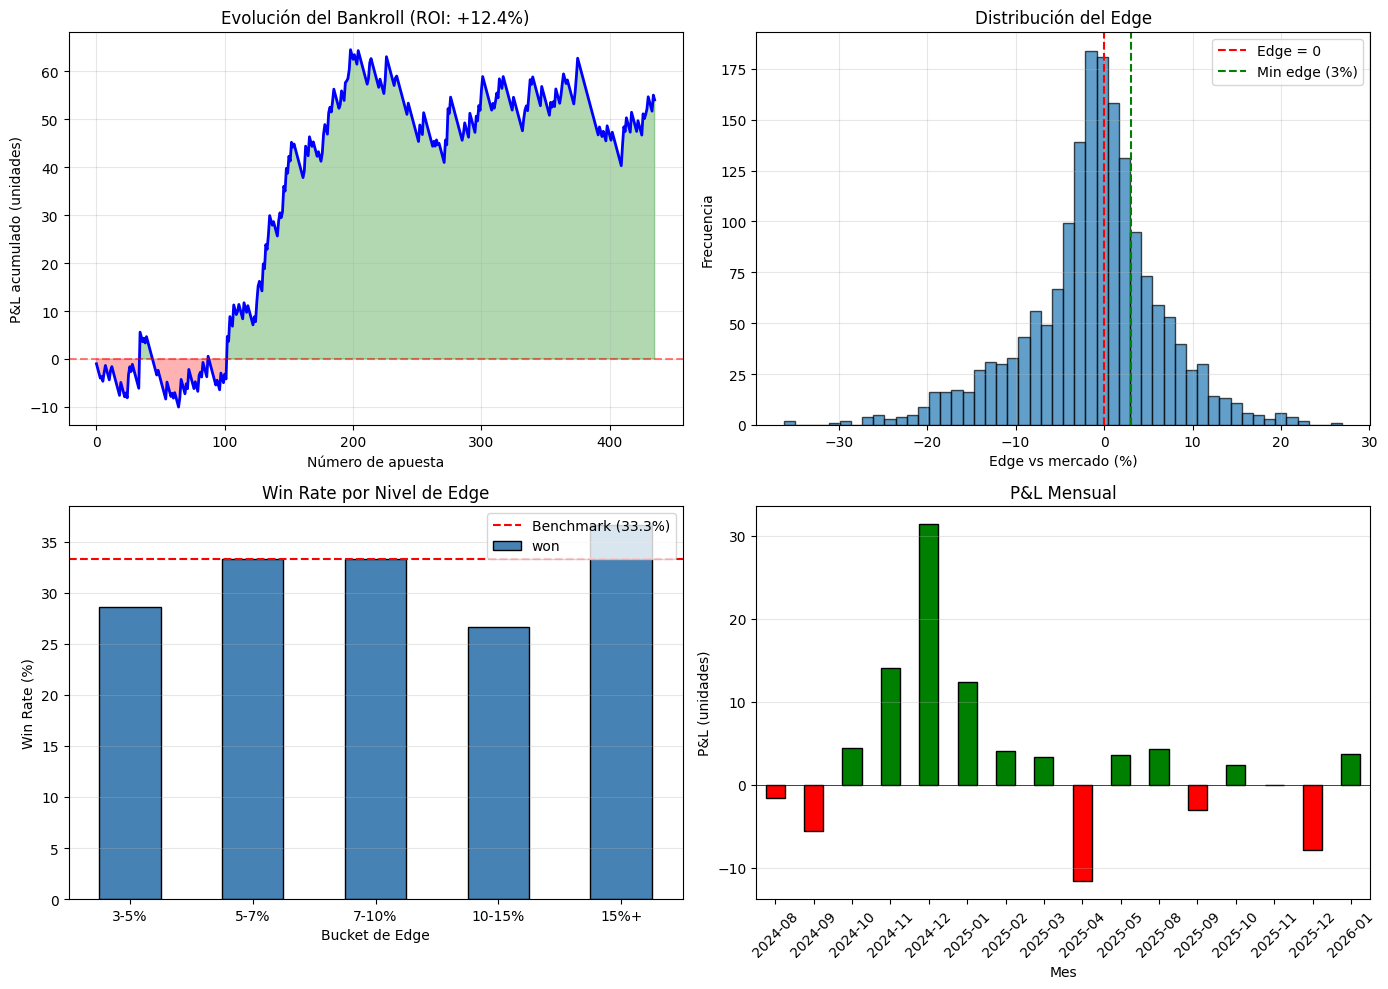

In [136]:
# Visualización del backtest
if backtest_results is not None and "value_bets" in backtest_results:
    value_bets = backtest_results["value_bets"]
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. Evolución del P&L
    ax1 = axes[0, 0]
    ax1.plot(range(len(value_bets)), value_bets["cumulative_pnl"].values, lw=2, color="blue")
    ax1.axhline(0, color="red", ls="--", alpha=0.5)
    ax1.fill_between(range(len(value_bets)), 0, value_bets["cumulative_pnl"].values,
                     where=value_bets["cumulative_pnl"].values >= 0, color="green", alpha=0.3)
    ax1.fill_between(range(len(value_bets)), 0, value_bets["cumulative_pnl"].values,
                     where=value_bets["cumulative_pnl"].values < 0, color="red", alpha=0.3)
    ax1.set_xlabel("Número de apuesta")
    ax1.set_ylabel("P&L acumulado (unidades)")
    ax1.set_title(f"Evolución del Bankroll (ROI: {backtest_results['roi']:+.1f}%)")
    ax1.grid(True, alpha=0.3)
    
    # 2. Distribución de edge
    ax2 = axes[0, 1]
    df_results = backtest_results["df_results"]
    ax2.hist(df_results["edge"] * 100, bins=50, edgecolor="black", alpha=0.7)
    ax2.axvline(0, color="red", ls="--", label="Edge = 0")
    ax2.axvline(3, color="green", ls="--", label="Min edge (3%)")
    ax2.set_xlabel("Edge vs mercado (%)")
    ax2.set_ylabel("Frecuencia")
    ax2.set_title("Distribución del Edge")
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Win rate por edge bucket
    ax3 = axes[1, 0]
    value_bets_copy = value_bets.copy()
    value_bets_copy["edge_bucket"] = pd.cut(value_bets_copy["edge"] * 100, 
                                             bins=[3, 5, 7, 10, 15, 100],
                                             labels=["3-5%", "5-7%", "7-10%", "10-15%", "15%+"])
    win_rate_by_edge = value_bets_copy.groupby("edge_bucket", observed=True)["won"].mean() * 100
    win_rate_by_edge.plot(kind="bar", ax=ax3, color="steelblue", edgecolor="black")
    ax3.axhline(33.3, color="red", ls="--", label="Benchmark (33.3%)")
    ax3.set_xlabel("Bucket de Edge")
    ax3.set_ylabel("Win Rate (%)")
    ax3.set_title("Win Rate por Nivel de Edge")
    ax3.legend()
    ax3.tick_params(axis='x', rotation=0)
    ax3.grid(True, alpha=0.3, axis="y")
    
    # 4. P&L por mes
    ax4 = axes[1, 1]
    value_bets_copy["month"] = pd.to_datetime(value_bets_copy["date"]).dt.to_period("M")
    monthly_pnl = value_bets_copy.groupby("month")["pnl"].sum()
    colors = ["green" if x >= 0 else "red" for x in monthly_pnl.values]
    monthly_pnl.plot(kind="bar", ax=ax4, color=colors, edgecolor="black")
    ax4.axhline(0, color="black", lw=0.5)
    ax4.set_xlabel("Mes")
    ax4.set_ylabel("P&L (unidades)")
    ax4.set_title("P&L Mensual")
    ax4.tick_params(axis='x', rotation=45)
    ax4.grid(True, alpha=0.3, axis="y")
    
    plt.tight_layout()
    plt.show()
    
    # Resumen final
    print("\n" + "=" * 70)
    print("RESUMEN FINAL: ¿ES RENTABLE EL MODELO?")
    print("=" * 70)
    
    model_ll = backtest_results.get("model_ll")
    market_ll = backtest_results.get("market_ll")
    roi = backtest_results["roi"]
    
    print(f"\n1. LOG LOSS (capacidad predictiva):")
    if model_ll and market_ll:
        print(f"   Modelo: {model_ll:.4f}")
        print(f"   Mercado: {market_ll:.4f}")
        if model_ll < market_ll:
            print(f"   → Modelo es MÁS preciso que el mercado ✓")
        else:
            print(f"   → Mercado es más preciso que el modelo ✗")
    
    print(f"\n2. ROI (rentabilidad):")
    print(f"   ROI total: {roi:+.2f}%")
    if roi > 0:
        print(f"   → Modelo es RENTABLE ✓")
    else:
        print(f"   → Modelo NO es rentable ✗")
    
    print(f"\n3. CONCLUSIÓN:")
    if model_ll and market_ll and model_ll < market_ll and roi > 0:
        print(f"   ✓✓ El modelo SUPERA al mercado y es RENTABLE")
        print(f"   → Considerar uso real con gestión de bankroll adecuada")
    elif roi > 0:
        print(f"   ✓ El modelo es rentable pero el mercado es más preciso")
        print(f"   → Posible suerte/varianza, necesita más datos")
    elif model_ll and market_ll and model_ll < market_ll:
        print(f"   ~ El modelo es más preciso pero no rentable aún")
        print(f"   → Ajustar threshold de edge o mejorar modelo")
    else:
        print(f"   ✗ El modelo no supera al mercado ni es rentable")
        print(f"   → Necesita mejoras significativas")

## 9. Predicciones para la Próxima Jornada

Ahora sí, lo que viniste a buscar: **predicciones para la próxima jornada**.

El modelo ya está entrenado con todos los datos disponibles. Solo necesitas:
1. Definir los partidos de la jornada
2. (Opcional) Añadir las odds para encontrar value bets

In [ ]:
def predict_matchday(matches: list[tuple], model, odds: dict = None, min_edge: float = 0.03):
    """
    Genera predicciones para una lista de partidos.
    
    Args:
        matches: Lista de tuplas (home_team, away_team)
        model: Modelo Dixon-Coles entrenado
        odds: Diccionario opcional con odds del mercado
        min_edge: Edge minimo para considerar value bet
    
    Returns:
        DataFrame con predicciones incluyendo todos los mercados
    """
    from IPython.display import display, HTML
    
    predictions = []
    
    for home, away in matches:
        try:
            pred = predict_match(home, away, model)
            
            row = {
                "Partido": f"{home} vs {away}",
                "Local": home,
                "Visitante": away,
                "xG_Local": pred["lambda_home"],
                "xG_Visita": pred["mu_away"],
                # 1X2
                "P_1": pred["p_home"],
                "P_X": pred["p_draw"],
                "P_2": pred["p_away"],
                # Doble Oportunidad
                "P_1X": pred["p_1X"],
                "P_X2": pred["p_X2"],
                "P_12": pred["p_12"],
                # Over/Under
                "P_O15": pred["p_over_15"],
                "P_U15": pred["p_under_15"],
                "P_O25": pred["p_over_25"],
                "P_U25": pred["p_under_25"],
                "P_O35": pred["p_over_35"],
                "P_U35": pred["p_under_35"],
                # BTTS
                "P_BTTS": pred["p_btts_yes"],
                # Marcador (solo para display, no CSV)
                "Marcador": pred["most_likely_score"],
                # Prediccion simple
                "Prediccion": "1" if pred["p_home"] > max(pred["p_draw"], pred["p_away"]) 
                             else ("X" if pred["p_draw"] > pred["p_away"] else "2")
            }
            
            match_key = f"{home} vs {away}"
            if odds and match_key in odds:
                match_odds = odds[match_key]
                row["Odds_1"] = match_odds.get("home", None)
                row["Odds_X"] = match_odds.get("draw", None)
                row["Odds_2"] = match_odds.get("away", None)
                
                if row["Odds_1"]:
                    row["Edge_1"] = pred["p_home"] - 1/row["Odds_1"]
                if row["Odds_X"]:
                    row["Edge_X"] = pred["p_draw"] - 1/row["Odds_X"]
                if row["Odds_2"]:
                    row["Edge_2"] = pred["p_away"] - 1/row["Odds_2"]
            
            predictions.append(row)
            
        except Exception as e:
            print(f"Error en {home} vs {away}: {e}")
    
    df = pd.DataFrame(predictions)
    
    # === MOSTRAR PREDICCIONES ===
    print("=" * 120)
    print("PREDICCIONES PROXIMA JORNADA")
    print("=" * 120)
    
    decay_info = ""
    if model.get("use_decay"):
        decay_info = f", decay={model.get('half_life')}d"
    print(f"\nModelo: Dixon-Coles con xG (gamma={model['gamma']:.3f}, rho={model['rho']:.4f}{decay_info})")
    
    print(f"\n{'Partido':<35} {'xG':>9} {'P(1)':>6} {'P(X)':>6} {'P(2)':>6} {'O1.5':>5} {'O2.5':>5} {'O3.5':>5} {'BTTS':>5} {'Score':>5}")
    print("-" * 120)
    
    for _, row in df.iterrows():
        xg_str = f"{row['xG_Local']:.1f}-{row['xG_Visita']:.1f}"
        print(f"{row['Partido']:<35} {xg_str:>9} "
              f"{row['P_1']*100:>5.1f}% {row['P_X']*100:>5.1f}% {row['P_2']*100:>5.1f}% "
              f"{row['P_O15']*100:>4.0f}% {row['P_O25']*100:>4.0f}% {row['P_O35']*100:>4.0f}% "
              f"{row['P_BTTS']*100:>4.0f}% {row['Marcador']:>5}")
    
    # === MOSTRAR VALUE BETS ===
    if odds:
        value_bets = []
        
        for _, row in df.iterrows():
            for outcome, p_col, odds_col, edge_col in [
                ("1", "P_1", "Odds_1", "Edge_1"),
                ("X", "P_X", "Odds_X", "Edge_X"),
                ("2", "P_2", "Odds_2", "Edge_2")
            ]:
                if edge_col in row and pd.notna(row.get(edge_col)) and row[edge_col] >= min_edge:
                    kelly = kelly_fraction(row[p_col], row[odds_col], fraction=0.25)
                    value_bets.append({
                        "Partido": row["Partido"],
                        "Apuesta": outcome,
                        "Prob": row[p_col],
                        "Odds": row[odds_col],
                        "Edge": row[edge_col],
                        "Kelly": kelly
                    })
        
        if value_bets:
            value_bets = sorted(value_bets, key=lambda x: x["Edge"], reverse=True)
            
            html = """
            <h3>VALUE BETS (Edge >= 3%)</h3>
            <table style="border-collapse: collapse; width: 100%; font-family: monospace;">
            <tr style="background-color: #f0f0f0; font-weight: bold;">
                <th style="padding: 8px; text-align: left; border: 1px solid #ddd;">#</th>
                <th style="padding: 8px; text-align: left; border: 1px solid #ddd;">Partido</th>
                <th style="padding: 8px; text-align: center; border: 1px solid #ddd;">Apuesta</th>
                <th style="padding: 8px; text-align: right; border: 1px solid #ddd;">Prob</th>
                <th style="padding: 8px; text-align: right; border: 1px solid #ddd;">Odds</th>
                <th style="padding: 8px; text-align: right; border: 1px solid #ddd;">Edge</th>
                <th style="padding: 8px; text-align: right; border: 1px solid #ddd;">Kelly</th>
            </tr>
            """
            
            total_kelly = 0
            for i, vb in enumerate(value_bets, 1):
                total_kelly += vb["Kelly"]
                edge_color = "#28a745" if vb["Edge"] > 0.05 else "#17a2b8"
                html += f"""
                <tr>
                    <td style="padding: 8px; border: 1px solid #ddd;">{i}</td>
                    <td style="padding: 8px; border: 1px solid #ddd;">{vb['Partido']}</td>
                    <td style="padding: 8px; text-align: center; border: 1px solid #ddd; font-weight: bold;">{vb['Apuesta']}</td>
                    <td style="padding: 8px; text-align: right; border: 1px solid #ddd;">{vb['Prob']*100:.1f}%</td>
                    <td style="padding: 8px; text-align: right; border: 1px solid #ddd;">{vb['Odds']:.2f}</td>
                    <td style="padding: 8px; text-align: right; border: 1px solid #ddd; color: {edge_color}; font-weight: bold;">+{vb['Edge']*100:.1f}%</td>
                    <td style="padding: 8px; text-align: right; border: 1px solid #ddd;">{vb['Kelly']*100:.1f}%</td>
                </tr>
                """
            
            html += f"""
            <tr style="background-color: #f8f9fa; font-weight: bold;">
                <td colspan="6" style="padding: 8px; border: 1px solid #ddd; text-align: right;">TOTAL KELLY:</td>
                <td style="padding: 8px; text-align: right; border: 1px solid #ddd;">{total_kelly*100:.1f}%</td>
            </tr>
            </table>
            <p><strong>{len(value_bets)} value bets</strong> | Stake total: {total_kelly*100:.1f}% del bankroll</p>
            """
            
            display(HTML(html))
        else:
            print(f"\nNo hay value bets con edge >= {min_edge*100:.0f}%")
    
    return df


def show_available_teams(model):
    """Muestra los equipos disponibles en el modelo (debug)."""
    print("EQUIPOS DISPONIBLES:")
    for i, team in enumerate(sorted(model["teams"]), 1):
        print(f"  {i:2d}. {team}")

In [ ]:
# ============================================================
# PASO 1: OBTENER PARTIDOS Y ODDS (AUTO + FALLBACK MANUAL)
# ============================================================
import requests

ODDS_API_KEY = "6e04e5a29b50f3ea12c11834a14b3ca1"

# Mapeo the-odds-api -> Understat
ODDS_API_TEAM_MAP = {
    "Manchester United": "Manchester United",
    "Manchester City": "Manchester City",
    "Liverpool": "Liverpool",
    "Arsenal": "Arsenal",
    "Chelsea": "Chelsea",
    "Tottenham Hotspur": "Tottenham",
    "Newcastle United": "Newcastle United",
    "Brighton and Hove Albion": "Brighton",
    "Aston Villa": "Aston Villa",
    "West Ham United": "West Ham",
    "Brentford": "Brentford",
    "Fulham": "Fulham",
    "Crystal Palace": "Crystal Palace",
    "Wolverhampton Wanderers": "Wolverhampton Wanderers",
    "Everton": "Everton",
    "Nottingham Forest": "Nottingham Forest",
    "AFC Bournemouth": "Bournemouth",
    "Leeds United": "Leeds",
    "Burnley": "Burnley",
    "Sunderland AFC": "Sunderland",
}

# === FALLBACK: JORNADA 24 MANUAL ===
JORNADA_24_MANUAL = [
    # Sabado 31 Enero 2026
    ("Brighton", "Everton"),
    ("Leeds", "Arsenal"),
    ("Wolverhampton Wanderers", "Bournemouth"),
    ("Chelsea", "West Ham"),
    ("Liverpool", "Newcastle United"),
    # Domingo 1 Febrero 2026
    ("Aston Villa", "Brentford"),
    ("Manchester United", "Fulham"),
    ("Nottingham Forest", "Crystal Palace"),
    ("Tottenham", "Manchester City"),
    # Lunes 2 Febrero 2026
    ("Sunderland", "Burnley"),
]

def fetch_matches_and_odds(api_key, bookmaker="pinnacle"):
    """Descarga partidos y odds de the-odds-api.com"""
    url = "https://api.the-odds-api.com/v4/sports/soccer_epl/odds/"
    params = {
        "apiKey": api_key,
        "regions": "eu",
        "markets": "h2h",
        "oddsFormat": "decimal",
        "bookmakers": bookmaker
    }
    
    try:
        response = requests.get(url, params=params, timeout=10)
        if response.status_code != 200:
            return None, None, f"HTTP {response.status_code}"
        
        remaining = response.headers.get("x-requests-remaining", "?")
        data = response.json()
        
        if not data:
            return None, None, "No hay partidos"
        
        matches = []
        odds_dict = {}
        
        for event in data:
            home_api = event["home_team"]
            away_api = event["away_team"]
            home = ODDS_API_TEAM_MAP.get(home_api, home_api)
            away = ODDS_API_TEAM_MAP.get(away_api, away_api)
            
            matches.append((home, away))
            match_key = f"{home} vs {away}"
            
            for bm in event.get("bookmakers", []):
                if bm["key"] == bookmaker:
                    for market in bm.get("markets", []):
                        if market["key"] == "h2h":
                            outcomes = {o["name"]: o["price"] for o in market["outcomes"]}
                            odds_dict[match_key] = {
                                "home": outcomes.get(home_api),
                                "draw": outcomes.get("Draw"),
                                "away": outcomes.get(away_api)
                            }
        
        return matches, odds_dict, remaining
    except Exception as e:
        return None, None, str(e)


# === EJECUTAR ===
print("=" * 70)
print("PASO 1: OBTENER PARTIDOS Y ODDS")
print("=" * 70)

# Intentar API automatica
print("\n[1] Intentando descarga automatica de the-odds-api.com...")
matches_api, odds_api, status = fetch_matches_and_odds(ODDS_API_KEY)

if matches_api:
    # Filtrar equipos conocidos
    proxima_jornada = [(h, a) for h, a in matches_api if h in model["teams"] and a in model["teams"]]
    
    # Limitar a 10 partidos (1 jornada)
    if len(proxima_jornada) > 10:
        proxima_jornada = proxima_jornada[:10]
    
    # Filtrar odds
    odds_api = {f"{h} vs {a}": odds_api.get(f"{h} vs {a}") for h, a in proxima_jornada}
    
    print(f"    OK - {len(proxima_jornada)} partidos descargados")
    print(f"    Requests restantes: {status}")
    
else:
    # Fallback manual
    print(f"    FALLO: {status}")
    print("\n[2] Usando partidos MANUALES (Jornada 24)...")
    
    proxima_jornada = [(h, a) for h, a in JORNADA_24_MANUAL if h in model["teams"] and a in model["teams"]]
    odds_api = {}
    
    print(f"    OK - {len(proxima_jornada)} partidos configurados")
    print("    (Sin odds - predicciones sin comparacion de mercado)")

# Mostrar partidos
print(f"\n{'='*70}")
print("PARTIDOS A PREDECIR:")
print("="*70)
for i, (h, a) in enumerate(proxima_jornada, 1):
    odds = odds_api.get(f"{h} vs {a}", {})
    if odds:
        print(f"  {i:2d}. {h} vs {a}  |  1={odds.get('home','?')} X={odds.get('draw','?')} 2={odds.get('away','?')}")
    else:
        print(f"  {i:2d}. {h} vs {a}")

In [ ]:
# ============================================================
# PASO 2: GENERAR PREDICCIONES
# ============================================================
# Usa los partidos y odds del Paso 1

if proxima_jornada and len(proxima_jornada) > 0:
    # Generar predicciones
    df_predictions = predict_matchday(
        proxima_jornada, 
        model, 
        odds=odds_api if odds_api else None, 
        min_edge=0.03
    )
else:
    df_predictions = None
    print("No hay partidos para predecir")
    print("Ejecuta primero el Paso 1")

In [ ]:
# ============================================================
# PASO 3: EXPORTAR PREDICCIONES (OPCIONAL)
# ============================================================
from datetime import datetime

def export_predictions(df_pred, filename=None):
    """Exporta predicciones a CSV formateado con todos los mercados."""
    if filename is None:
        filename = f"predicciones_{datetime.now().strftime('%Y%m%d_%H%M')}.csv"
    
    df_export = df_pred.copy()
    
    # Formatear xG
    for col in ["xG_Local", "xG_Visita"]:
        if col in df_export.columns:
            df_export[col] = df_export[col].round(2)
    
    # Formatear probabilidades (todas las P_*)
    prob_cols = [c for c in df_export.columns if c.startswith("P_")]
    for col in prob_cols:
        df_export[col] = (df_export[col] * 100).round(1).astype(str) + "%"
    
    # Formatear Edges
    for col in ["Edge_1", "Edge_X", "Edge_2"]:
        if col in df_export.columns:
            df_export[col] = df_export[col].apply(
                lambda x: f"{x*100:+.1f}%" if pd.notna(x) else ""
            )
    
    # Formatear Odds
    for col in ["Odds_1", "Odds_X", "Odds_2"]:
        if col in df_export.columns:
            df_export[col] = df_export[col].round(2)
    
    # Seleccionar columnas en orden logico para el CSV (SIN Marcador)
    col_order = [
        "Local", "Visitante", "xG_Local", "xG_Visita",
        "P_1", "P_X", "P_2",
        "P_1X", "P_X2", "P_12",
        "P_O15", "P_U15", "P_O25", "P_U25", "P_O35", "P_U35",
        "P_BTTS",
        "Prediccion"
    ]
    
    # Agregar columnas de odds si existen
    odds_cols = ["Odds_1", "Odds_X", "Odds_2", "Edge_1", "Edge_X", "Edge_2"]
    for col in odds_cols:
        if col in df_export.columns:
            col_order.append(col)
    
    # Filtrar solo columnas que existen
    col_order = [c for c in col_order if c in df_export.columns]
    df_export = df_export[col_order]
    
    df_export.to_csv(filename, index=False)
    print(f"Exportado: {filename}")
    print(f"  Partidos: {len(df_export)}")
    print(f"  Columnas: {len(col_order)}")
    
    return filename

# === EXPORTAR ===
if 'df_predictions' in dir() and df_predictions is not None:
    export_predictions(df_predictions)
else:
    print("No hay predicciones para exportar")
    print("  Ejecuta primero Paso 1 y Paso 2")

## 10. ROI Tracking

Sistema para registrar apuestas, actualizar resultados y calcular el ROI real del modelo.

In [ ]:
# ============================================================
# ROI TRACKING - Registro y Seguimiento de Apuestas
# ============================================================
import os
from datetime import datetime

BETS_FILE = "bets_history.csv"

def init_bets_file():
    """Crea el archivo de apuestas si no existe."""
    if not os.path.exists(BETS_FILE):
        df = pd.DataFrame(columns=[
            "fecha", "partido", "mercado", "seleccion",
            "prob_modelo", "odds", "stake", "edge",
            "resultado", "profit", "settled"
        ])
        df.to_csv(BETS_FILE, index=False)
        print(f"Archivo creado: {BETS_FILE}")


def log_bet(partido, mercado, seleccion, prob_modelo, odds, stake=1.0):
    """
    Registra una nueva apuesta.
    
    Args:
        partido: "Liverpool vs Arsenal"
        mercado: "1X2", "Over2.5", "BTTS", etc.
        seleccion: "1", "X", "2", "Over", "Under", "Si", "No"
        prob_modelo: Probabilidad segun nuestro modelo (0-1)
        odds: Cuota decimal
        stake: Unidades apostadas (default 1)
    
    Example:
        log_bet("Liverpool vs Arsenal", "1X2", "1", 0.55, 2.10, stake=1.5)
    """
    init_bets_file()
    
    edge = prob_modelo - (1/odds)
    
    new_bet = {
        "fecha": datetime.now().strftime("%Y-%m-%d %H:%M"),
        "partido": partido,
        "mercado": mercado,
        "seleccion": seleccion,
        "prob_modelo": round(prob_modelo, 4),
        "odds": odds,
        "stake": stake,
        "edge": round(edge, 4),
        "resultado": "",
        "profit": "",
        "settled": False
    }
    
    df = pd.read_csv(BETS_FILE)
    df = pd.concat([df, pd.DataFrame([new_bet])], ignore_index=True)
    df.to_csv(BETS_FILE, index=False)
    
    print(f"Apuesta registrada:")
    print(f"  {partido} | {mercado} {seleccion} @ {odds}")
    print(f"  Prob: {prob_modelo*100:.1f}% | Edge: {edge*100:+.1f}% | Stake: {stake}u")


def log_bets_from_predictions(df_pred, mercado="1X2", min_edge=0.03, stake_mode="flat", base_stake=1.0):
    """
    Registra apuestas automaticamente desde las predicciones.
    
    Args:
        df_pred: DataFrame de predict_matchday()
        mercado: "1X2" por ahora
        min_edge: Edge minimo para apostar
        stake_mode: "flat" o "kelly"
        base_stake: Stake base (para flat) o bankroll % (para kelly)
    """
    init_bets_file()
    count = 0
    
    for _, row in df_pred.iterrows():
        for outcome, p_col, odds_col, edge_col in [
            ("1", "P_1", "Odds_1", "Edge_1"),
            ("X", "P_X", "Odds_X", "Edge_X"),
            ("2", "P_2", "Odds_2", "Edge_2")
        ]:
            if edge_col not in row or pd.isna(row.get(edge_col)):
                continue
            
            edge = row[edge_col]
            if edge >= min_edge:
                prob = row[p_col]
                odds = row[odds_col]
                
                if stake_mode == "kelly":
                    stake = kelly_fraction(prob, odds, fraction=0.25) * base_stake
                else:
                    stake = base_stake
                
                if stake > 0:
                    log_bet(
                        partido=f"{row['Local']} vs {row['Visitante']}",
                        mercado=mercado,
                        seleccion=outcome,
                        prob_modelo=prob,
                        odds=odds,
                        stake=round(stake, 2)
                    )
                    count += 1
    
    print(f"\nTotal: {count} apuestas registradas")


def update_result(partido, mercado, resultado_real):
    """
    Actualiza el resultado de un partido.
    
    Args:
        partido: "Liverpool vs Arsenal"
        mercado: "1X2", "Over2.5", etc.
        resultado_real: "1", "X", "2", "Over", "Under", etc.
    
    Example:
        update_result("Liverpool vs Arsenal", "1X2", "1")  # Gano Liverpool
    """
    df = pd.read_csv(BETS_FILE)
    
    mask = (df["partido"] == partido) & (df["mercado"] == mercado) & (df["settled"] == False)
    
    if mask.sum() == 0:
        print(f"No se encontro apuesta pendiente para {partido} ({mercado})")
        return
    
    for idx in df[mask].index:
        seleccion = df.loc[idx, "seleccion"]
        odds = df.loc[idx, "odds"]
        stake = df.loc[idx, "stake"]
        
        if seleccion == resultado_real:
            profit = stake * (odds - 1)
            df.loc[idx, "resultado"] = "WIN"
        else:
            profit = -stake
            df.loc[idx, "resultado"] = "LOSS"
        
        df.loc[idx, "profit"] = round(profit, 2)
        df.loc[idx, "settled"] = True
        
        print(f"{partido} | {mercado} {seleccion}: {df.loc[idx, 'resultado']} ({profit:+.2f}u)")
    
    df.to_csv(BETS_FILE, index=False)


def show_roi_stats():
    """Muestra estadisticas de ROI."""
    if not os.path.exists(BETS_FILE):
        print("No hay apuestas registradas")
        return
    
    df = pd.read_csv(BETS_FILE)
    
    if len(df) == 0:
        print("No hay apuestas registradas")
        return
    
    settled = df[df["settled"] == True]
    pending = df[df["settled"] == False]
    
    print("=" * 60)
    print("ROI TRACKING - ESTADISTICAS")
    print("=" * 60)
    
    print(f"\nAPUESTAS:")
    print(f"  Total: {len(df)}")
    print(f"  Settled: {len(settled)}")
    print(f"  Pendientes: {len(pending)}")
    
    if len(settled) > 0:
        wins = len(settled[settled["resultado"] == "WIN"])
        losses = len(settled[settled["resultado"] == "LOSS"])
        win_rate = wins / len(settled) * 100
        
        total_stake = settled["stake"].sum()
        total_profit = settled["profit"].sum()
        roi = (total_profit / total_stake) * 100 if total_stake > 0 else 0
        
        avg_odds = settled["odds"].mean()
        avg_edge = settled["edge"].mean() * 100
        
        print(f"\nRESULTADOS:")
        print(f"  Wins: {wins} | Losses: {losses}")
        print(f"  Win Rate: {win_rate:.1f}%")
        print(f"  Odds promedio: {avg_odds:.2f}")
        print(f"  Edge promedio: {avg_edge:+.1f}%")
        
        print(f"\nPROFIT:")
        print(f"  Stake total: {total_stake:.2f}u")
        print(f"  Profit: {total_profit:+.2f}u")
        print(f"  ROI: {roi:+.1f}%")
        
        # Por mercado
        print(f"\nPOR MERCADO:")
        for mercado in settled["mercado"].unique():
            m_df = settled[settled["mercado"] == mercado]
            m_profit = m_df["profit"].sum()
            m_stake = m_df["stake"].sum()
            m_roi = (m_profit / m_stake) * 100 if m_stake > 0 else 0
            m_wins = len(m_df[m_df["resultado"] == "WIN"])
            print(f"  {mercado}: {m_wins}/{len(m_df)} wins | {m_profit:+.2f}u | ROI: {m_roi:+.1f}%")
    
    if len(pending) > 0:
        print(f"\nPENDIENTES:")
        for _, row in pending.iterrows():
            print(f"  {row['partido']} | {row['mercado']} {row['seleccion']} @ {row['odds']}")
    
    return df


def show_pending_bets():
    """Muestra solo apuestas pendientes."""
    if not os.path.exists(BETS_FILE):
        print("No hay apuestas registradas")
        return
    
    df = pd.read_csv(BETS_FILE)
    pending = df[df["settled"] == False]
    
    if len(pending) == 0:
        print("No hay apuestas pendientes")
        return
    
    print(f"APUESTAS PENDIENTES ({len(pending)}):")
    print("-" * 70)
    for _, row in pending.iterrows():
        print(f"  {row['partido']} | {row['mercado']} {row['seleccion']} @ {row['odds']} | {row['stake']}u")
    
    return pending


# === EJEMPLOS DE USO ===
# 
# Registrar apuesta manual:
#   log_bet("Liverpool vs Arsenal", "1X2", "1", 0.55, 2.10)
#
# Registrar desde predicciones (todas las value bets):
#   log_bets_from_predictions(df_predictions, min_edge=0.03)
#
# Actualizar resultado:
#   update_result("Liverpool vs Arsenal", "1X2", "1")  # Gano Liverpool
#   update_result("Liverpool vs Arsenal", "1X2", "X")  # Empate
#
# Ver estadisticas:
#   show_roi_stats()
#
# Ver pendientes:
#   show_pending_bets()